In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import datetime, pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def convert(filename, delimiter=",", print_intermediate=True):
    """
    Returns a tuple with the dataframe and the column names
    """
    # Get dataframe and headers from csv
    df = pd.read_csv(filename, delimiter,header=0)
    header_list = list(df.columns)

    if print_intermediate:
        # Print what we got
        print("\nObtained a dataframe with the following fields:")
        print("\n", df.dtypes, "\n")
        print("\nDataframe description:")
        print("#"*100+"\n", df, "\n"+"#"*100+"\n")
    print("\nHeaders:")
    print("#"*100,"\n", header_list, "\n"+"#"*100+"\n")

    return (df, header_list)

FILENAME = "nyt_ts.csv"
intermediate = convert(FILENAME, ",", False)
election_df = intermediate[0]
headers = intermediate[1]


Headers:
#################################################################################################### 
 ['Unnamed: 0', 'votes', 'eevp', 'eevp_source', 'timestamp', 'state', 'expected_votes', 'trump2016', 'votes2012', 'votes2016', 'vote_share_rep', 'vote_share_dem', 'vote_share_trd'] 
####################################################################################################



In [3]:
# Convert strings representing datetime objects to datetime objects

def clean_column(df, column_name, error_values=[999]):
    """
    error_values is a list to be removed from column df[column_name]
    returns a dataframe with just one column
    """
    column = list(df[column_name][~df[column_name].isin(error_values)])
    # Creating a new dataframe
    cleaned = pd.DataFrame({column_name: column})

    return cleaned


def getdatetimes(df, 
                 column_name, 
                 format = '%Y-%m-%d %H:%M:%S',
                 print_intermediate=True,
                 error_values=[""]):
    """
    Converts one column containing datetimes as strings to a dataframe containing datetimes
    """

    column = clean_column(df, column_name, error_values)
    dates = pd.to_datetime(column[column_name], format=format)

    if print_intermediate:
        print(column_name)
        print(dates)
        
    return dates

    
def splitdatetime(df, 
                  column_name,
                  format = '%Y-%m-%d %H:%M:%S',
                  print_intermediate=True,
                  error_values = [999]):
    """
    Add columns to dataframe with year, month, weekday, hour
    column_name: column containing datetime objects
    """
    df[column_name] = getdatetimes(df, column_name, format, print_intermediate, error_values)
    df['year']      = [d.year for d in df[column_name]]
    df['month']     = [d.month for d in df[column_name]]
    df['weekday']   = [datetime.date(d.year, d.month, d.day).isoweekday() for d in df[column_name]]
    df['hour']      = [d.hour for d in df[column_name]]

    if print_intermediate:
        print("\nProcessed datetimes:")
        print("#"*100+"\n", df, "\n"+"#"*100+"\n")

    return df

splitdatetime(election_df, 'timestamp', '%Y-%m-%d %H:%M:%S', False)

,Unnamed: 0,votes,eevp,eevp_source,timestamp,state,expected_votes,trump2016,votes2012,votes2016,vote_share_rep,vote_share_dem,vote_share_trd,year,month,weekday,hour
0,0,0,0,edison,2020-11-04 10:01:44+00:00,alaska,367000,163387,300495,318608,0.000,0.000,0,2020,11,3,10
1,1,113744,31,edison,2020-11-04 07:47:41+00:00,alaska,367000,163387,300495,318608,0.605,0.352,0,2020,11,3,7
2,2,132475,36,edison,2020-11-04 08:57:55+00:00,alaska,367000,163387,300495,318608,0.614,0.347,0,2020,11,3,8
3,3,172031,56,edison,2020-11-04 18:34:58+00:00,alaska,367000,163387,300495,318608,0.629,0.330,0,2020,11,3,18
4,4,0,0,edison,2020-11-04 10:02:44+00:00,alabama,2300000,1318255,2074338,2123372,0.000,0.000,0,2020,11,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8406,8406,268852,93,edison,2020-11-04 08:29:35+00:00,wyoming,280000,174419,249061,255849,0.697,0.268,0,2020,11,3,8
8407,8407,271429,94,edison,2020-11-04 08:45:32+00:00,wyoming,280000,174419,249061,255849,0.698,0.267,0,2020,11,3,8
8408,8408,276343,95,edison,2020-11-04 08:50:19+00:00,wyoming,280000,174419,249061,255849,0.699,0.266,0,2020,11,3,8
8409,8409,276343,99,edison,2020-11-05 03:23:59+00:00,wyoming,280000,174419,249061,255849,0.699,0.266,0,2020,11,4,3


In [4]:
# Add calculated columns

def add_deltas(df, column_sort, column_name, col_new='deltas', print_intermediate=True):
    """
    Sort a df by column column_sort
    Copy a column with column_name, shift it one row down, then save the difference between event i and event i-1 in another column named [column_name]_prev
    Returns dataframe
    """
    df_  = df.sort_values(by=[column_sort])
    df__ = df_.reset_index(drop=True)
    new_name = column_name+'_prev'
    df__[new_name] = df__[column_name].shift(+1)
    s = df__[column_name] - df__[new_name]

    if print_intermediate:
        print("Differences:")
        pprint.pprint(s)

    # Convert timedeltas to integers and add to df
    deltas = pd.to_numeric(s)
    df__[col_new] = deltas

    return df__


def add_ratios(df, column_name1, column_name2, col_new='ratios', print_intermediate=True):
    """
    Divide a column by another column
    Returns dataframe
    """
    s = df[column_name1] / df[column_name2]

    if print_intermediate:
        print("Ratios:")
        pprint.pprint(s)

    # Convert timedeltas to integers and add to df
    ratios = pd.to_numeric(s)
    df[col_new] = ratios

#     indexNames = df[ df['delta'] < 0 ].index
#     df.drop(indexNames , inplace=True)
    df[col_new] = df[col_new].fillna(0)
    
    return df
    
    

In [5]:
# Add ration between parties 

election_df = add_ratios(election_df, 'vote_share_rep', 'vote_share_dem', 'ratio_rep_vs_dem', True)

Ratios:
0            NaN
1       1.718750
2       1.769452
3       1.906061
4            NaN
          ...   
8406    2.600746
8407    2.614232
8408    2.627820
8409    2.627820
8410    2.631579
Length: 8411, dtype: float64


In [6]:
# Get state names
states = election_df.state.unique()
# print(states_clean)

In [7]:
# Build queries to filter election_df by state
queries = [(s, 'state == \"{0}\"'.format(s)) for s in states]
# print (queries)

In [8]:
# Make queries
resultsByState = [(q[0], election_df.query(q[1])) for q in queries]
# print(resultsByState[0])

In [9]:
# Get minimum and maximum timestamps
timestamps = election_df.timestamp.unique()
earliest = min(timestamps)
latest = max(timestamps)

print ("Tallying begins at {0} and goes on until {1}.".format(earliest, latest))


Tallying begins at 2020-11-03 14:16:25+00:00 and goes on until 2020-11-09 04:50:49+00:00.


In [10]:
# Draw charts in rows, arranged by state
def charts_by_state (df_list, column_x, column_y, xlim, ylim, xformat, yformat, x0, x1, y, figsize, title=None, axes=None):
    """
    column_x, column_y: fields to be plotted
    x0: chart to the left
    x1: chart to the right
    y: row where both charts are
    title: optional or built from the names of x, y axes
    """
    
    if title == None: title = column_y.capitalize() + ' by ' + column_x.capitalize()
        
    title0 = str(x0) + ': ' + title + ' in ' + resultsByState[x0][0].replace('-', ' ').title()
    ax0 = df_list[x0][1].plot(x=column_x, y=column_y, kind='scatter', title=title0, 
                                #ax=axes[y, 0], 
                                rot=0, xlim=xlim, ylim=ylim, figsize=figsize)
    ax0.xaxis.set_major_formatter(xformat)
    ax0.yaxis.set_major_formatter(yformat)
    
    title1 = str(x1) + ': ' + title + ' in ' + resultsByState[x1][0].replace('-', ' ').title()
    ax1 = df_list[x1][1].plot(x=column_x, y=column_y, kind='scatter', title=title1, 
                                #ax=axes[y, 1], 
                                rot=0, xlim=xlim, ylim=ylim, figsize=figsize)
    ax0.xaxis.set_major_formatter(xformat)
    ax1.yaxis.set_major_formatter(yformat)
    
    return None

In [15]:
def chartset (df_list, column_x, column_y, categories, figsize=None, title=None, axes=None, dpi=None):
    """
    Build a plot chart set with column_x (name) and column_y (name) from dataframe dataframe 
    Categories: a list of items, there will be one chart for each
    """
    # Create chart distribution: charts will be rendered in pairs
    chartDistrib = [ (x, x+1) for x in list(range(len(categories))) if x % 2 == 0] 
    rows_no = len(chartDistrib)-1
    
    # Get uniform minimum and maximum values in x axis in all charts
    minima = [e[1][column_x].min() for e in df_list]
    maxima = [e[1][column_x].max() for e in df_list]
    xlim = min(minima), max(maxima)
    if type(xlim[0]) == float:
        xformat = mpl.ticker.StrMethodFormatter('{x:,.2f}')
        if xlim[0] >= 0 and xlim[1] <=1: 
            xlim = (0,1)
    elif type(xlim[0]) == int:
        xlim = None
        xformat = mpl.ticker.StrMethodFormatter('{x:,.0f}')
    else:
        xformat = mpl.dates.DateFormatter('%m-%d %Hh')

    # Get uniform format in y values in y axis in all charts
    minima = [e[1][column_y].min() for e in df_list]
    maxima = [e[1][column_y].max() for e in df_list]
    ylim = min(minima), max(maxima)
    figsize = [18,6]
    if type(ylim[0]) == float:
        yformat = mpl.ticker.StrMethodFormatter('{x:,.2f}')
        if ylim[0] >= 0 and ylim[1] <=1:
            ylim = (0,1)
            if figsize != None: figsize = [6,6]
        else:
            ylim = None
    elif type(ylim[0]) == int:
        ylim = None
        yformat = mpl.ticker.StrMethodFormatter('{x:,.0f}')
    else: 
        yformat = mpl.ticker.StrMethodFormatter('{x:,.0f}')
        if figsize != None: figsize = [18,6]
    
    if axes is not None:
        # fig, axes = plt.subplots(nrows=rows_no, ncols=2, figsize=FIGSIZE, dpi=MY_DPI)
        # fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
        pass
    
    # MY_DPI  = 96
    if dpi != None: figsize = (figsize[0]/dpi, figsize[1]/dpi)
    
    else:
        for pair in chartDistrib:
            x0, x1, y = pair[0], pair[1], (int(pair[1]/2))*0
            charts_by_state(df_list, column_x, column_y, xlim, ylim, xformat, yformat, x0, x1, y, figsize, None, None)
  


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


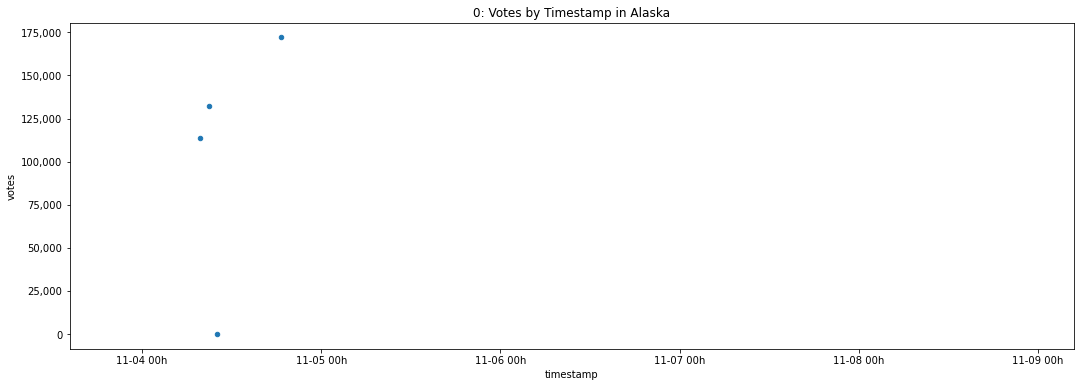

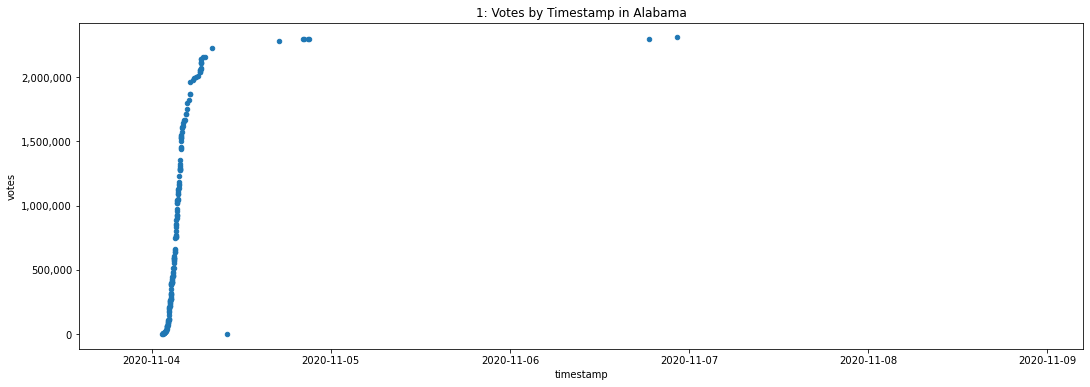

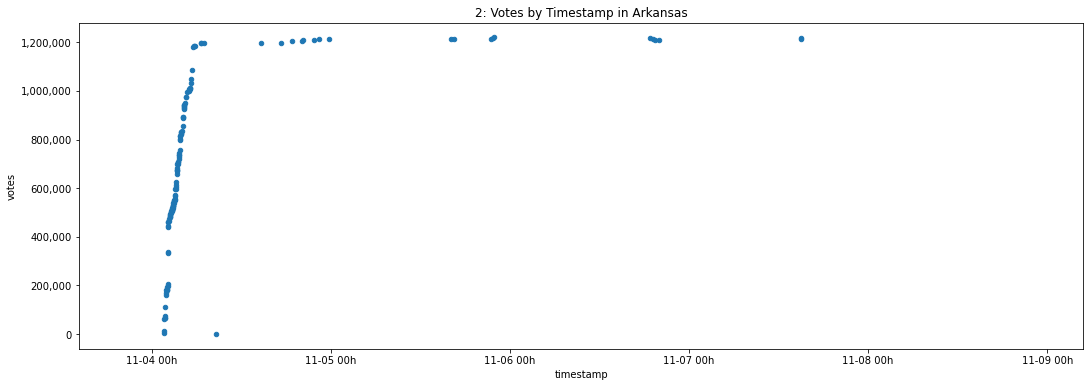

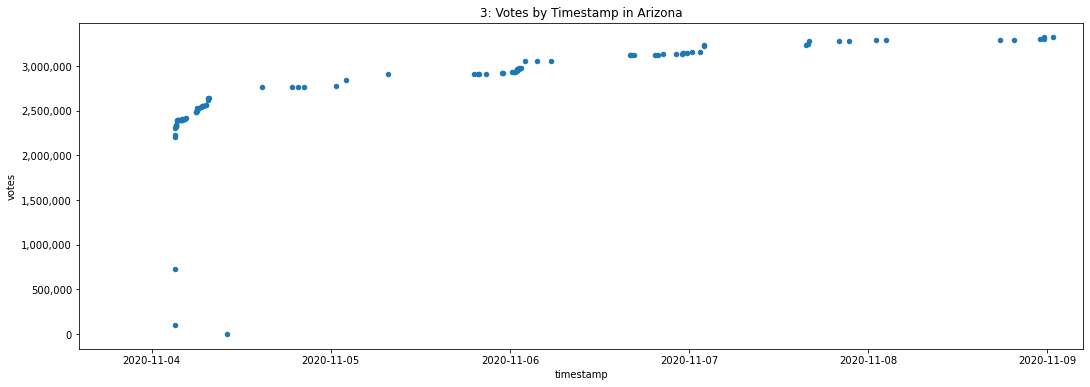

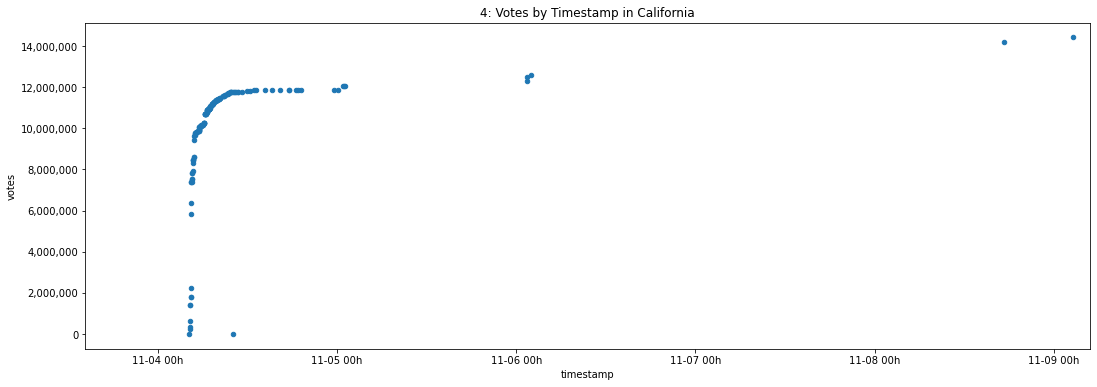

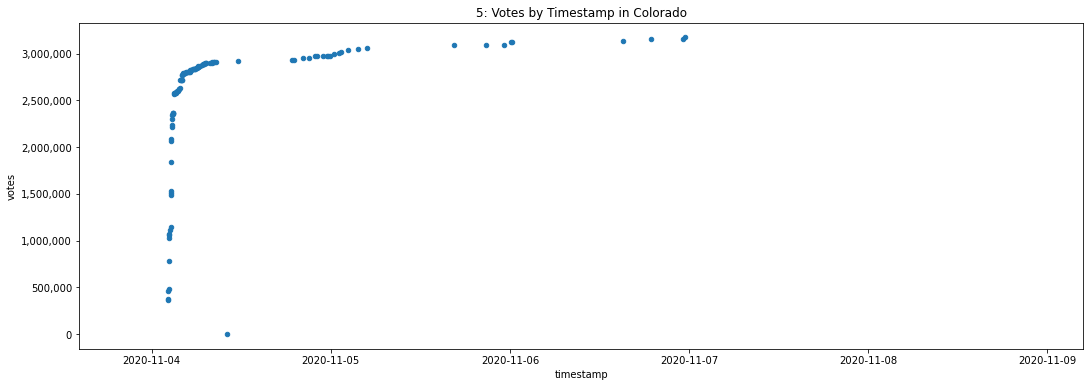

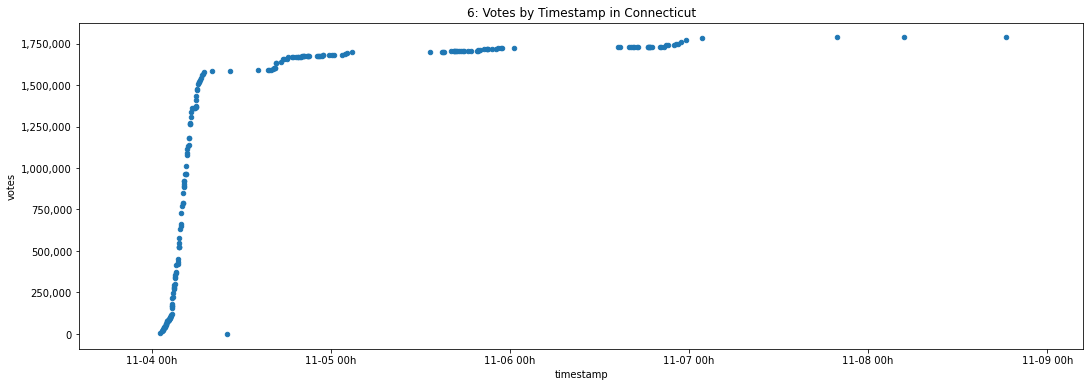

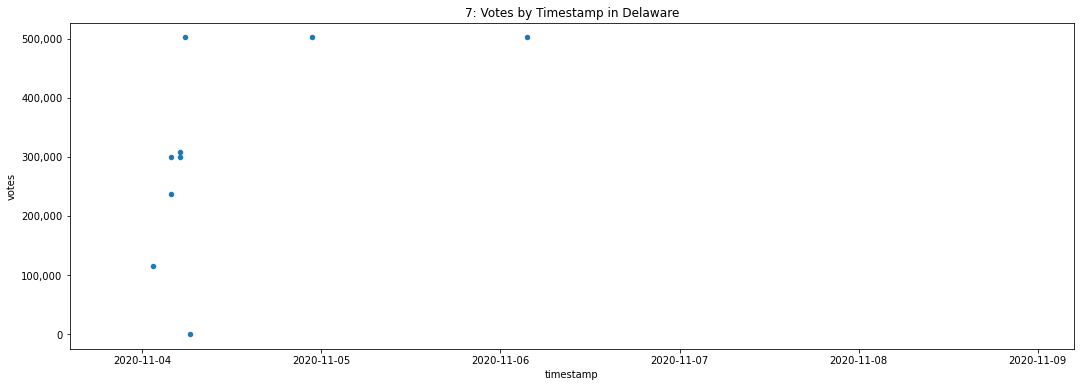

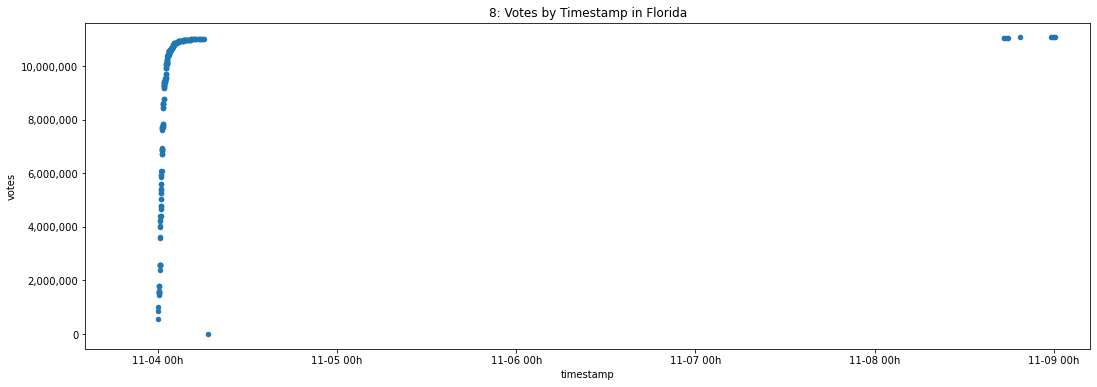

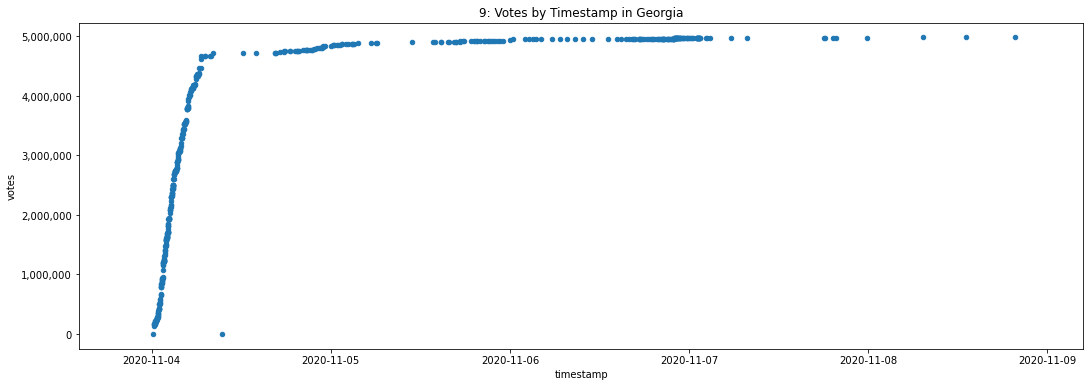

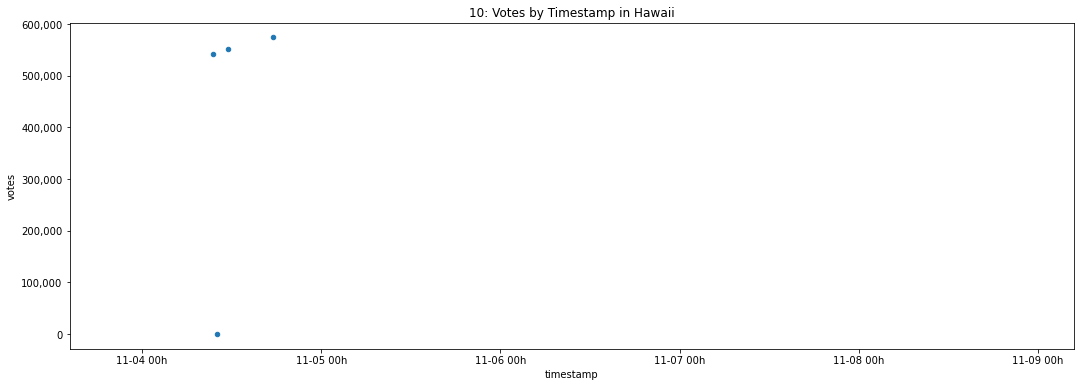

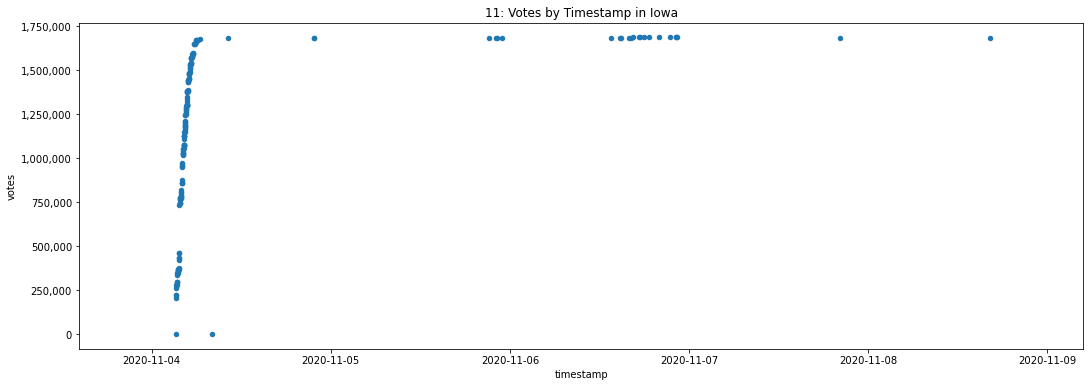

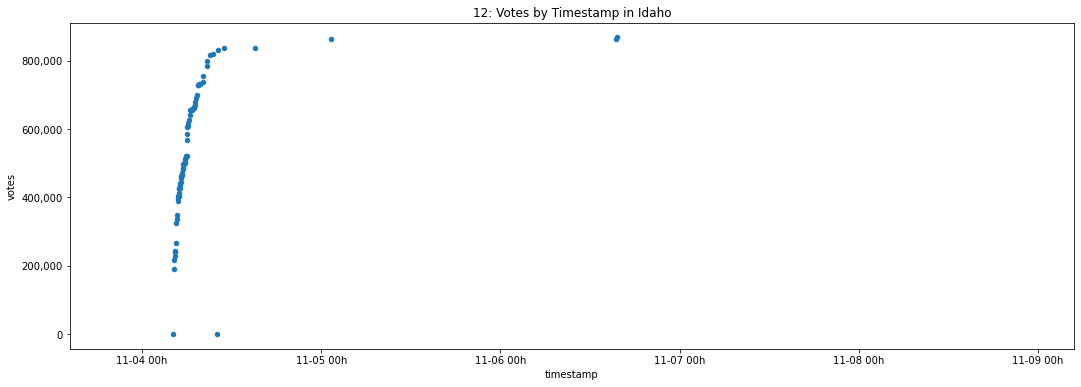

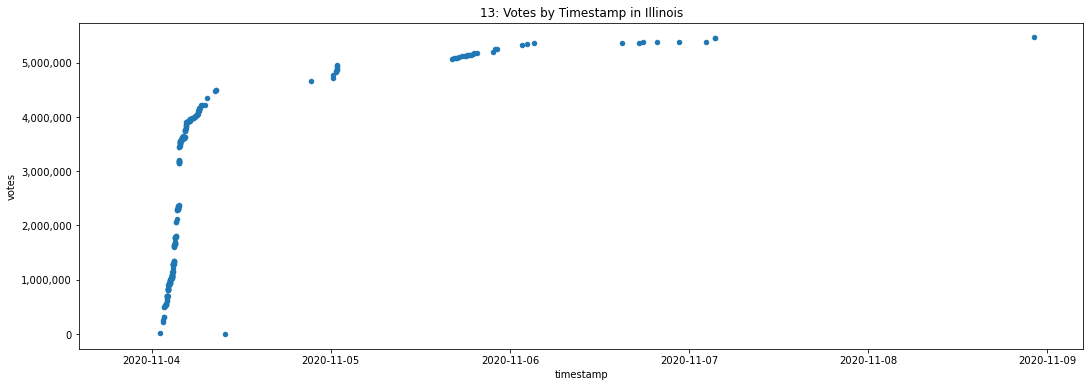

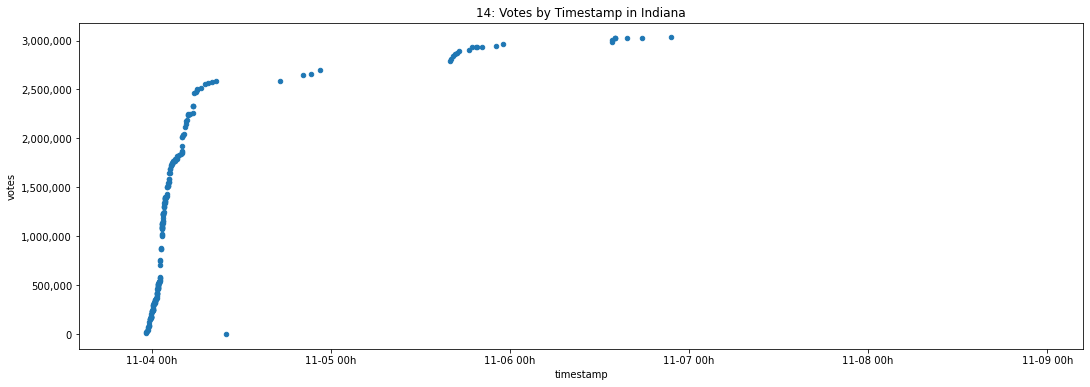

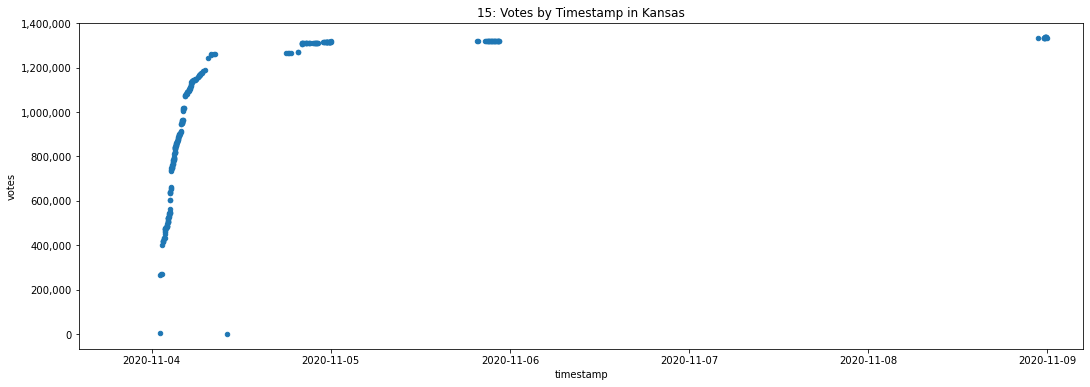

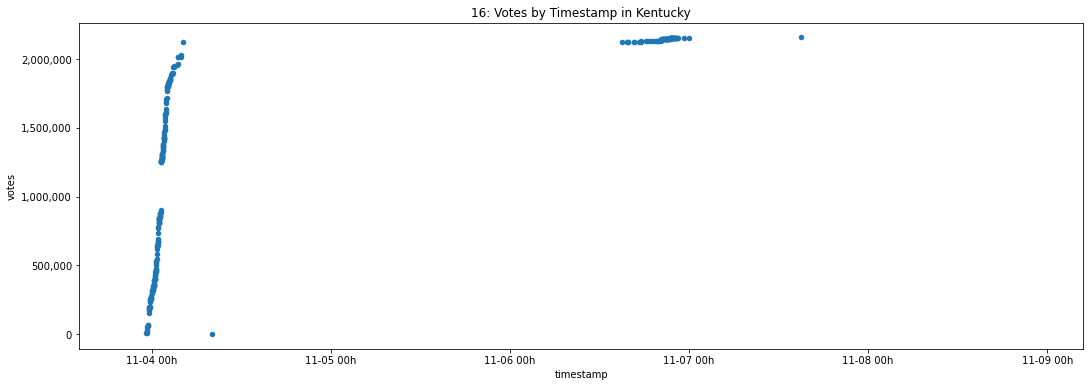

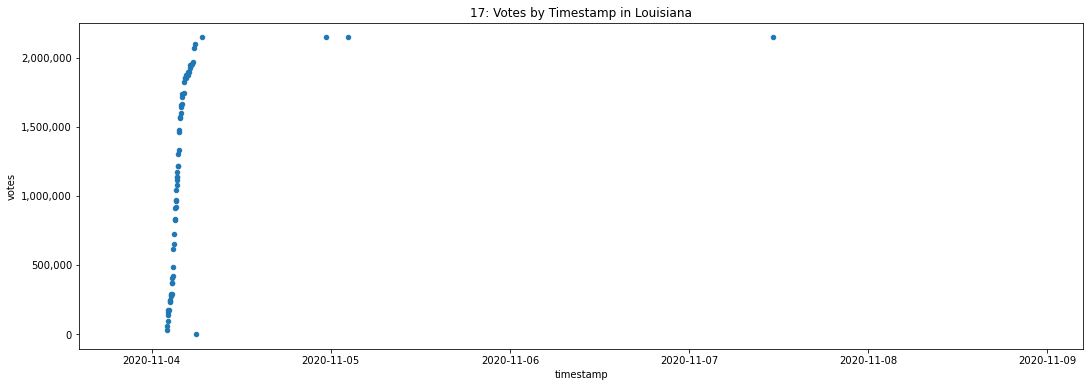

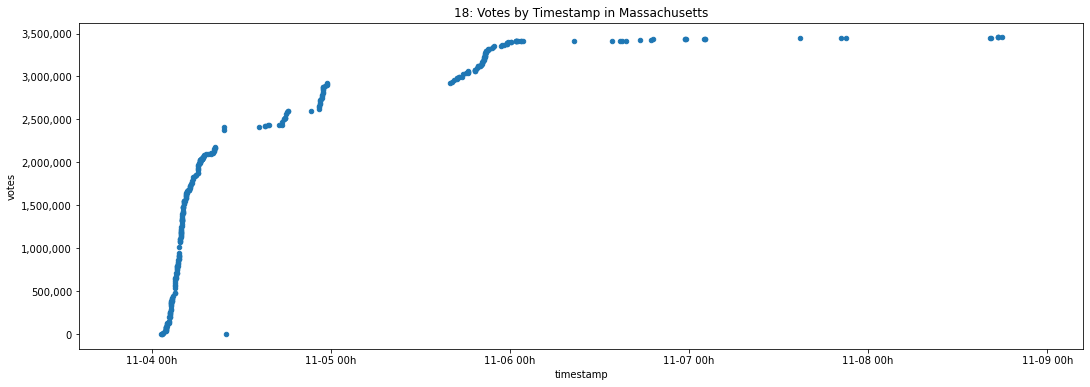

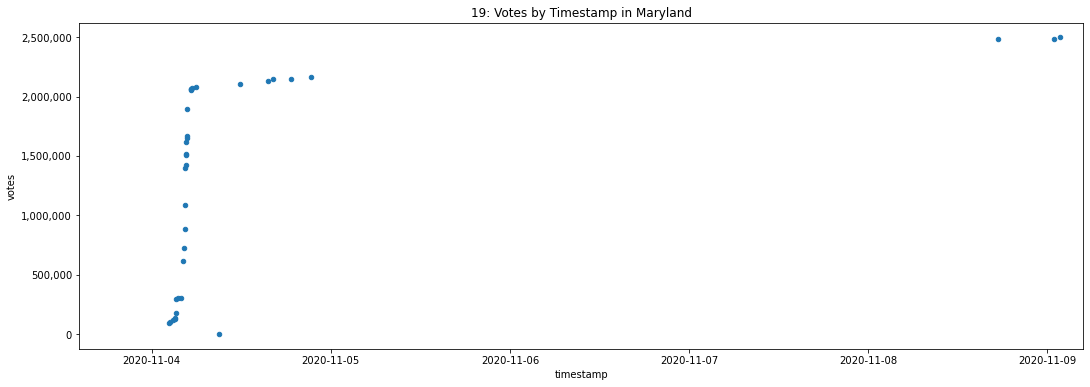

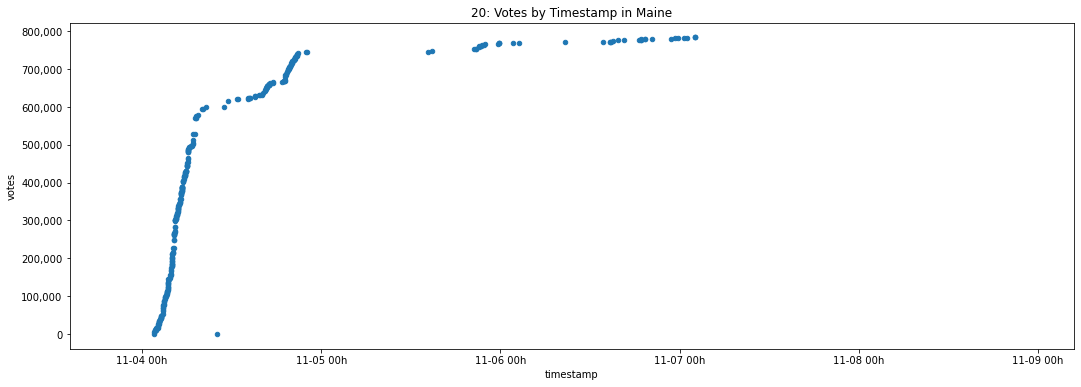

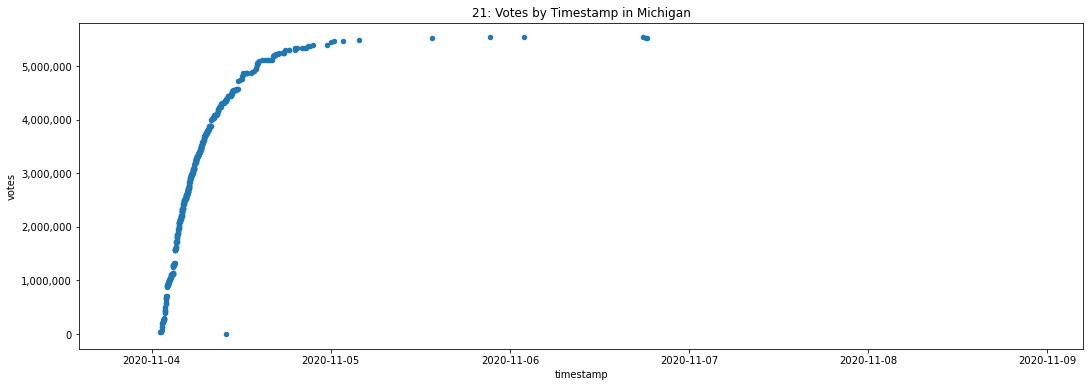

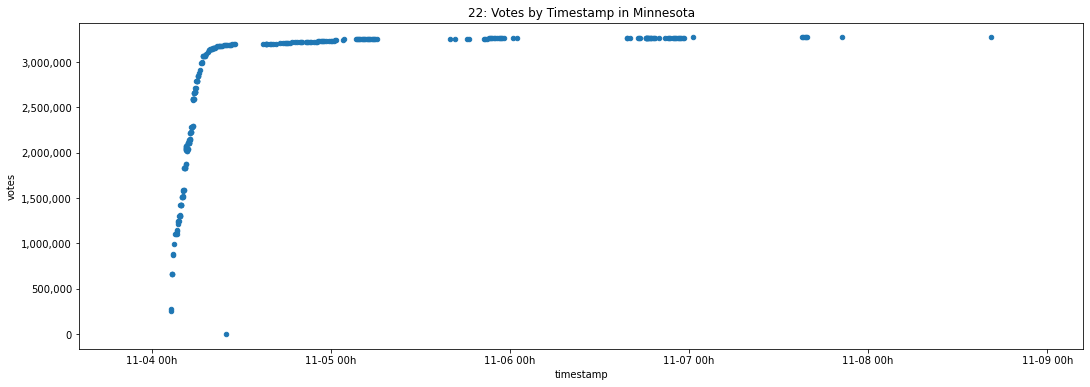

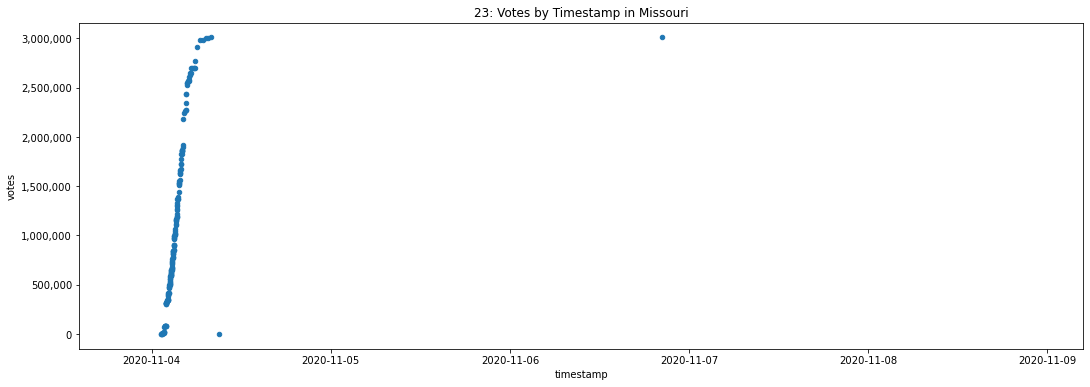

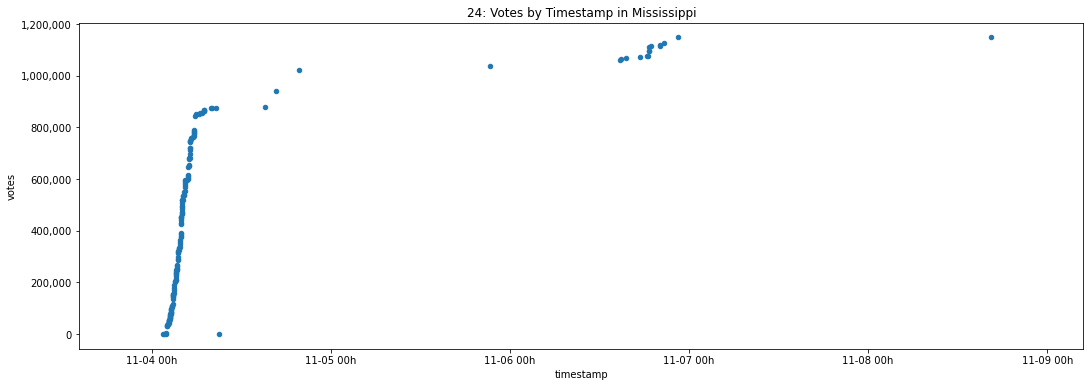

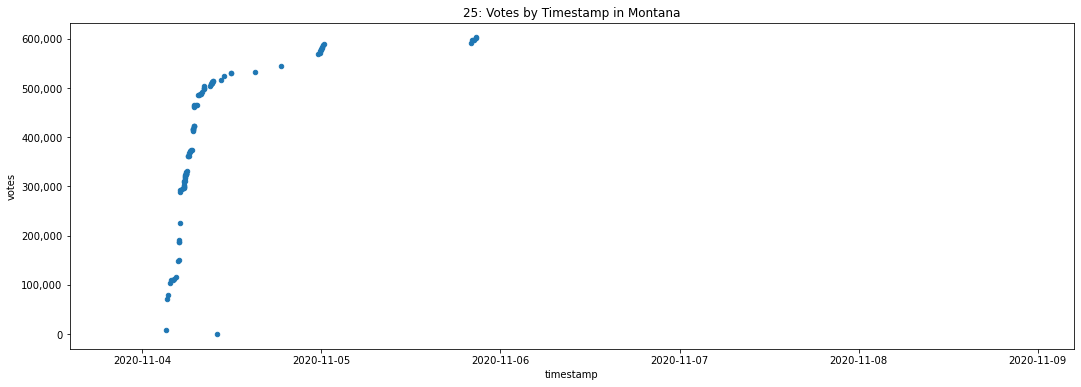

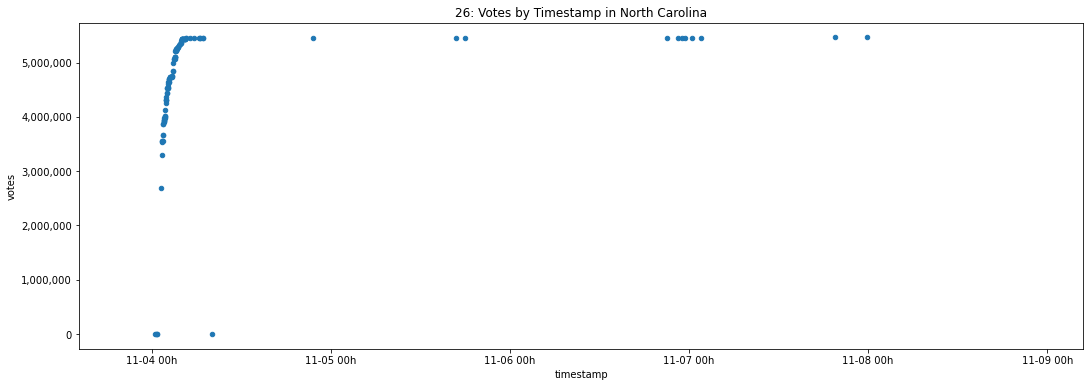

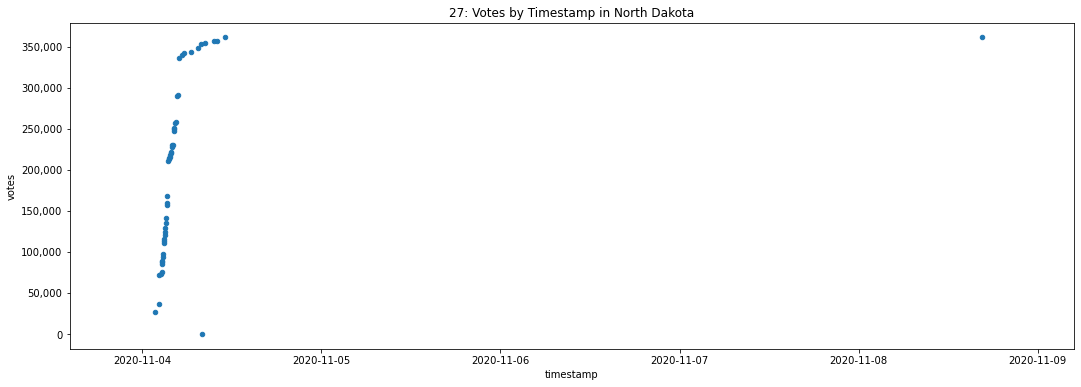

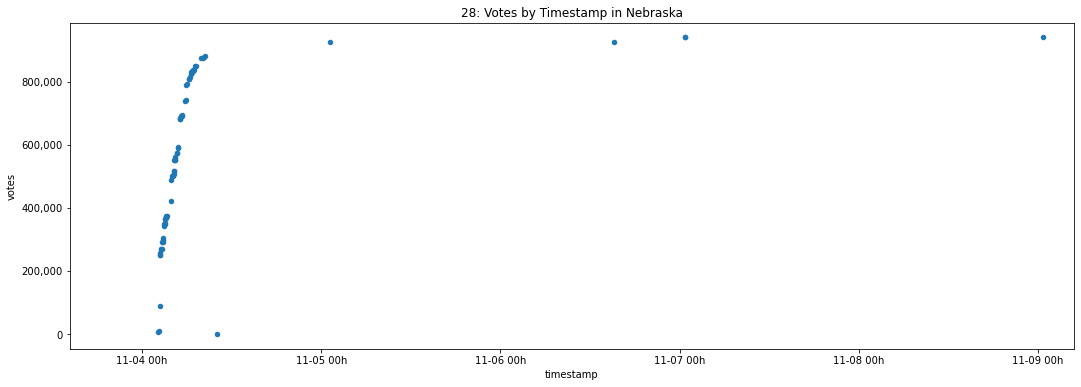

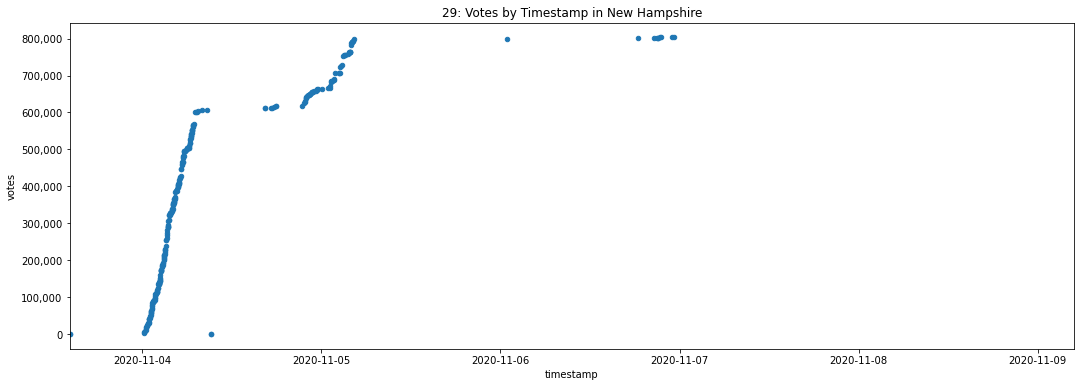

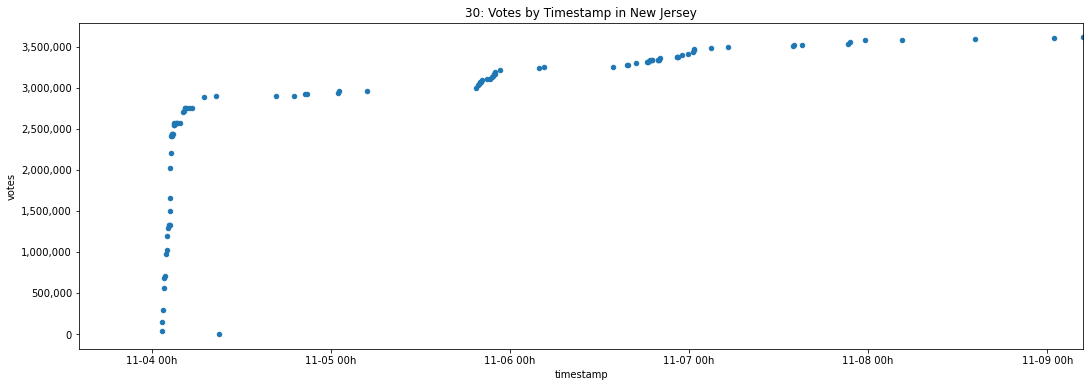

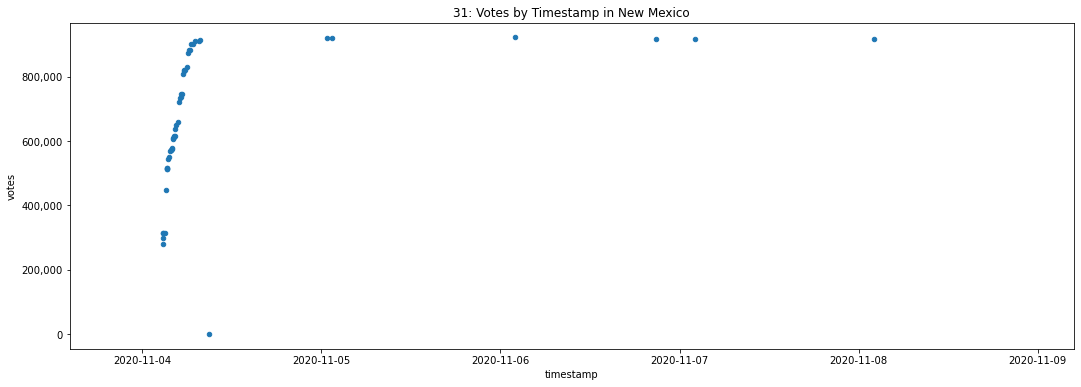

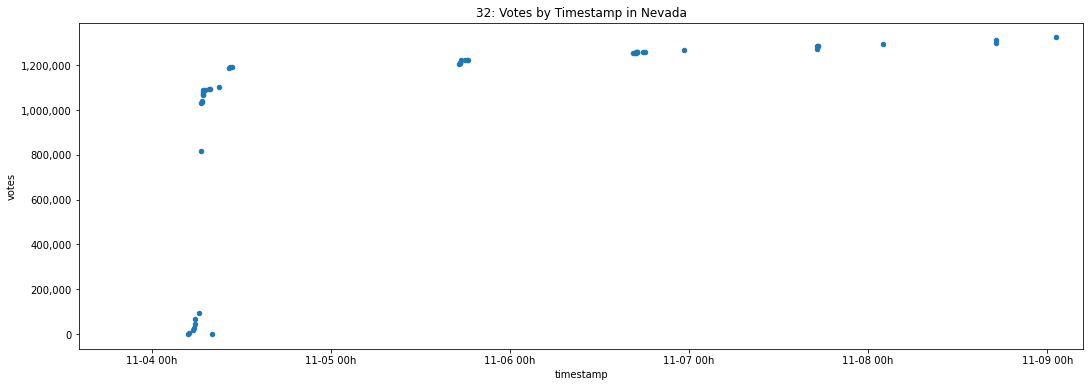

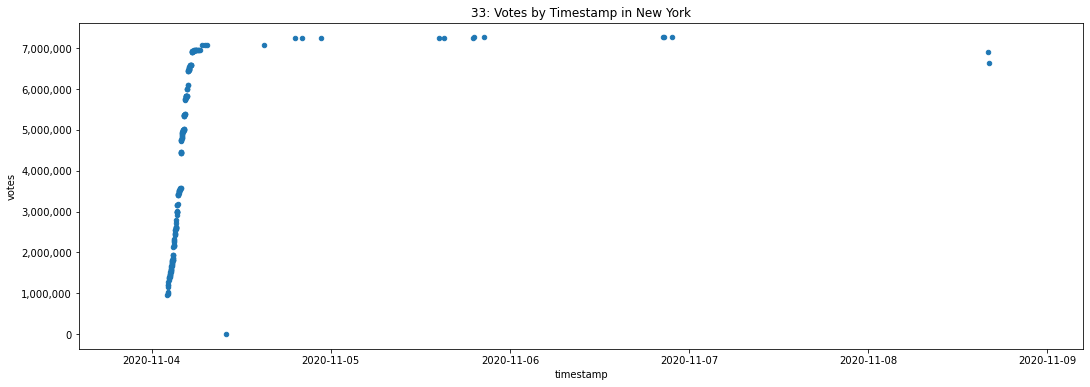

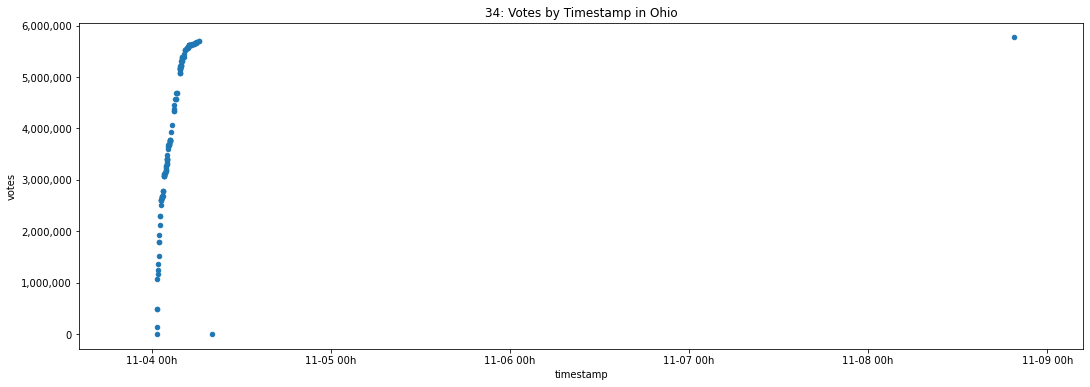

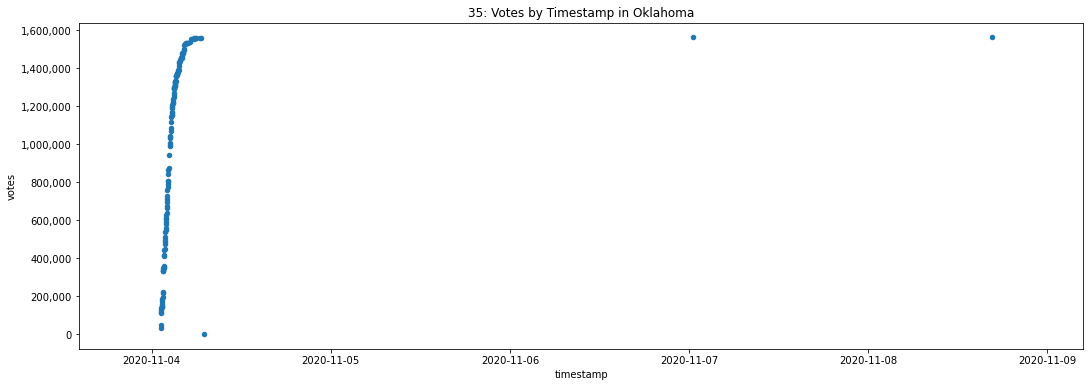

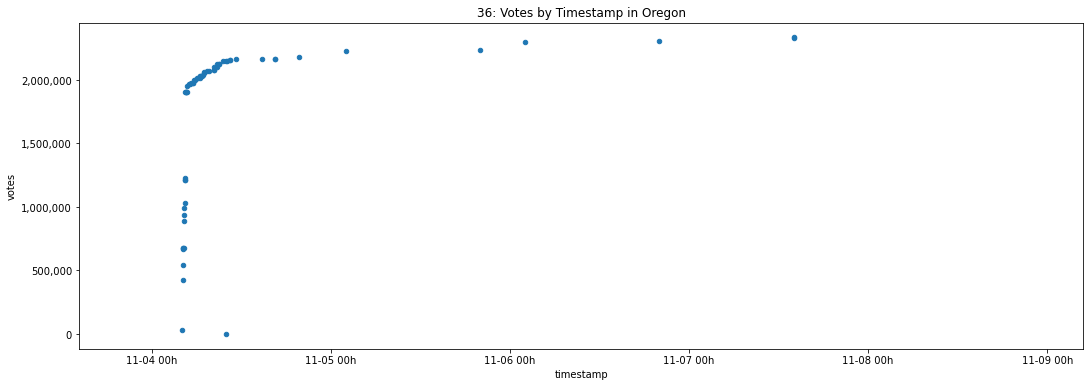

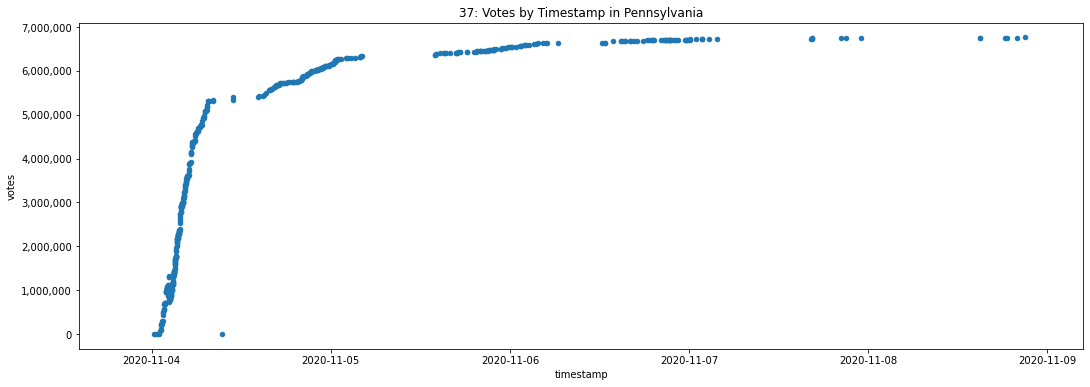

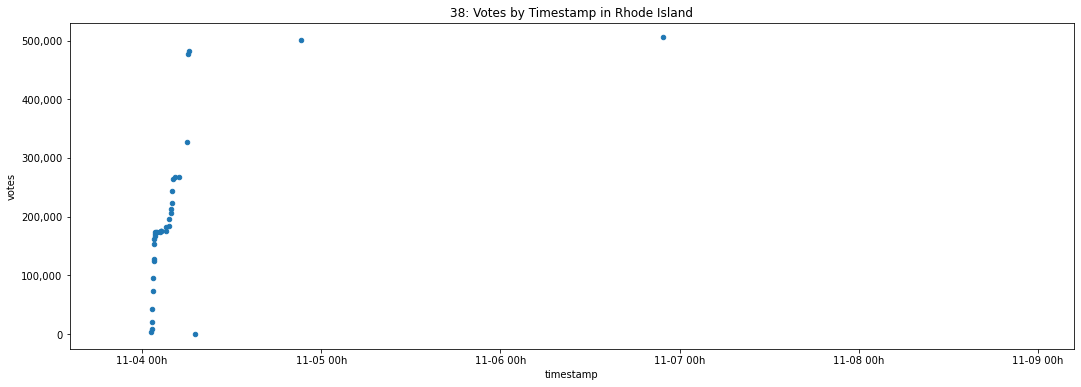

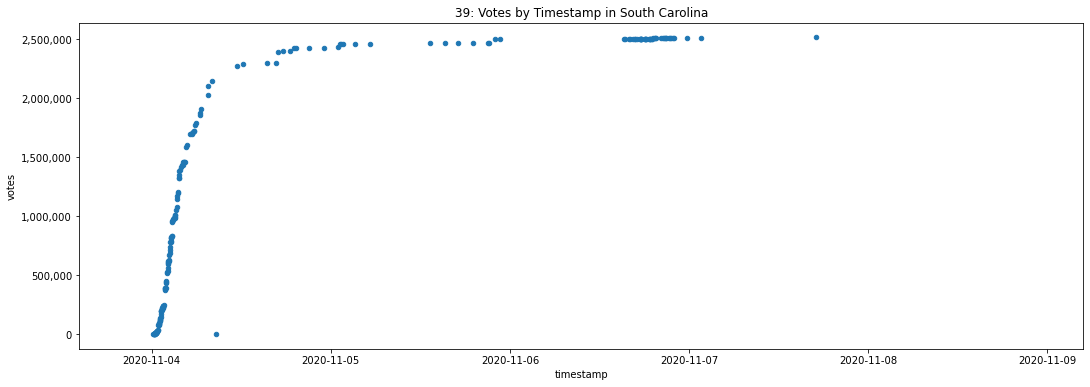

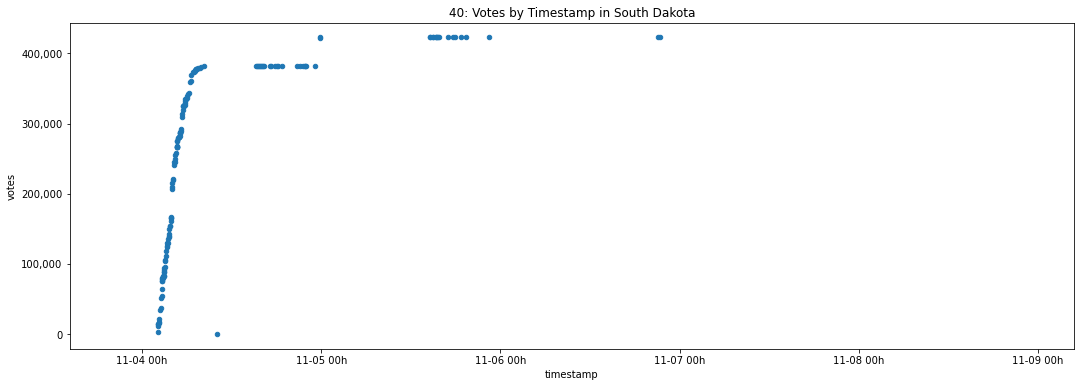

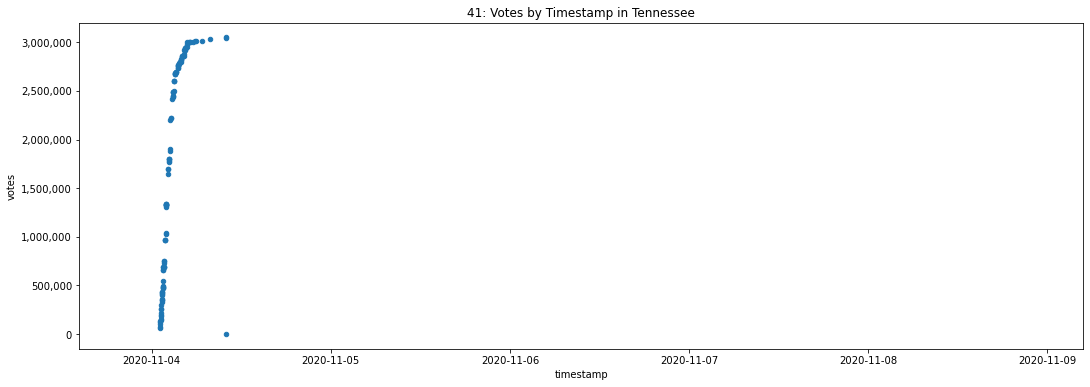

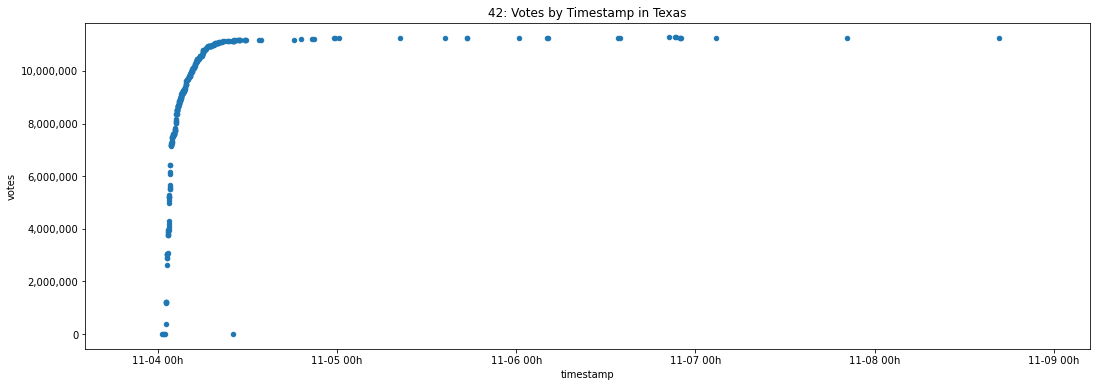

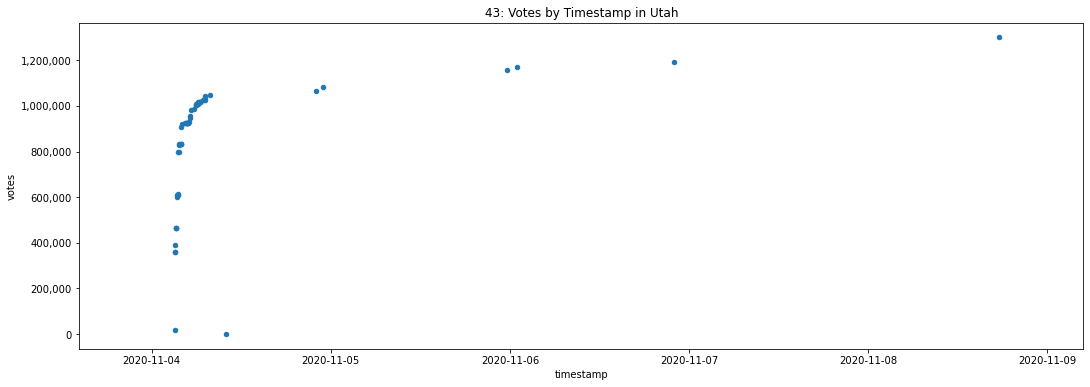

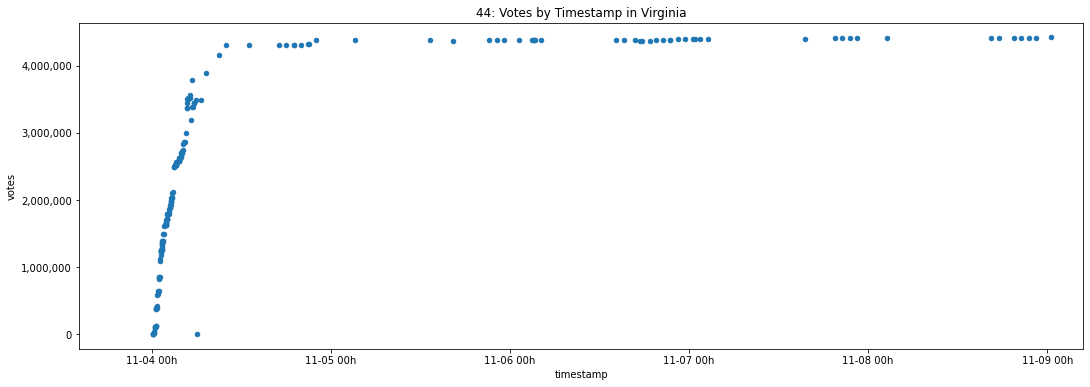

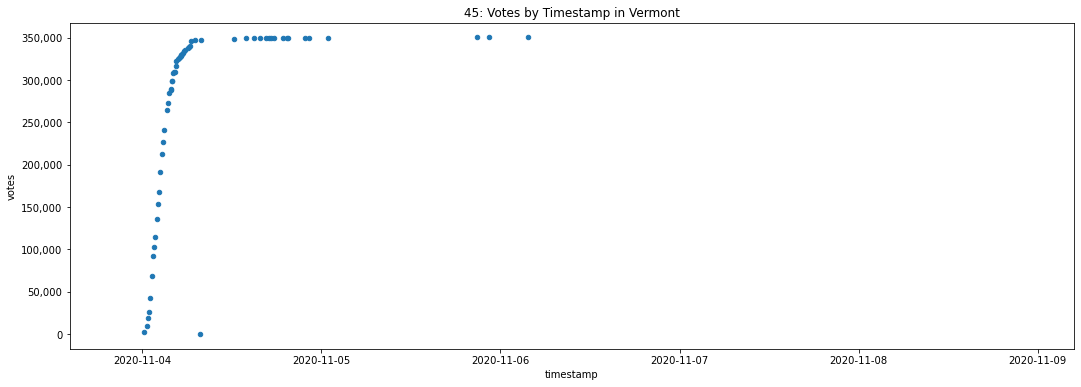

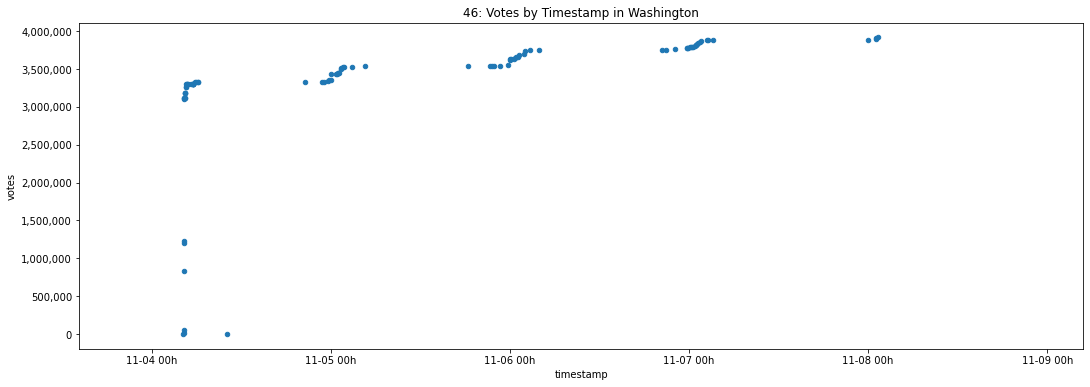

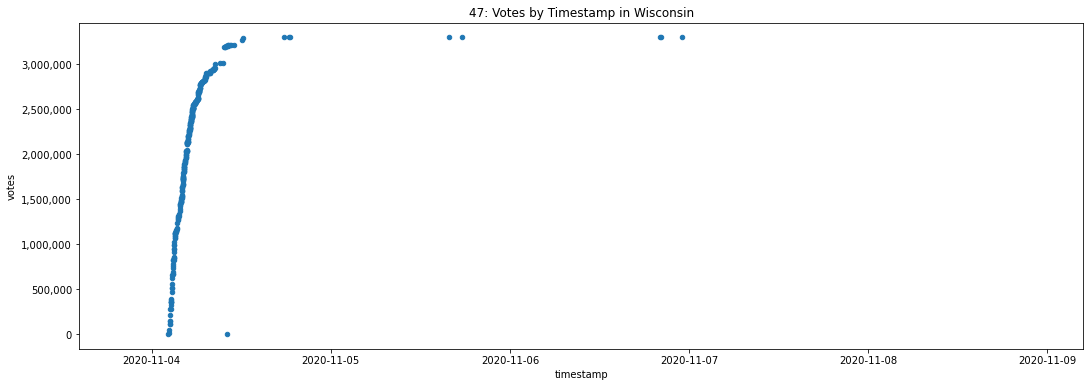

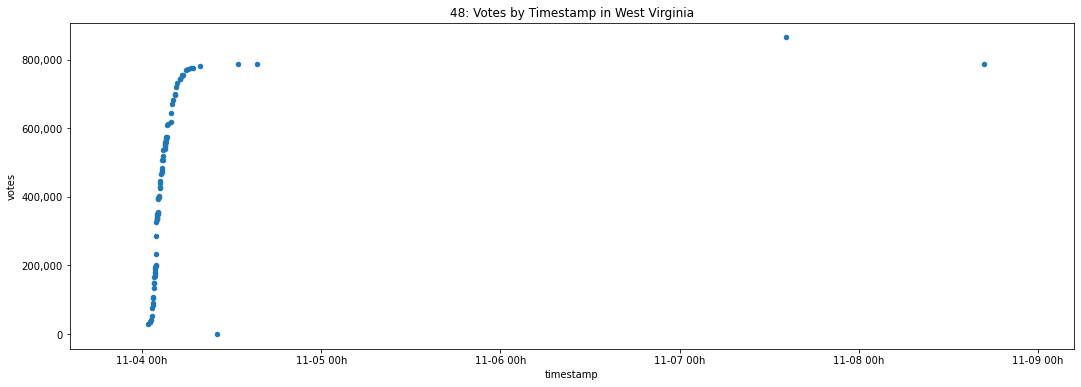

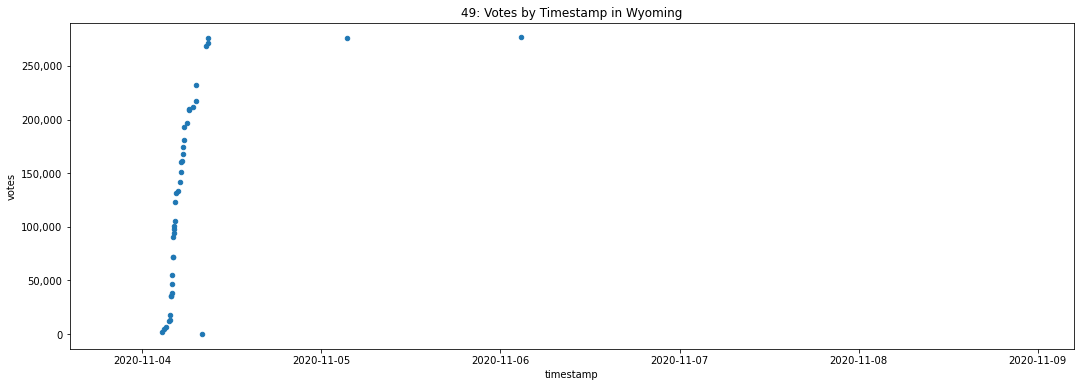

In [12]:
# Votes counted through time

chartset(resultsByState, 'timestamp', 'votes', states)

In [13]:
# Share of one party by share of the other party

# chartset(resultsByState, 'vote_share_dem', 'vote_share_rep', states)

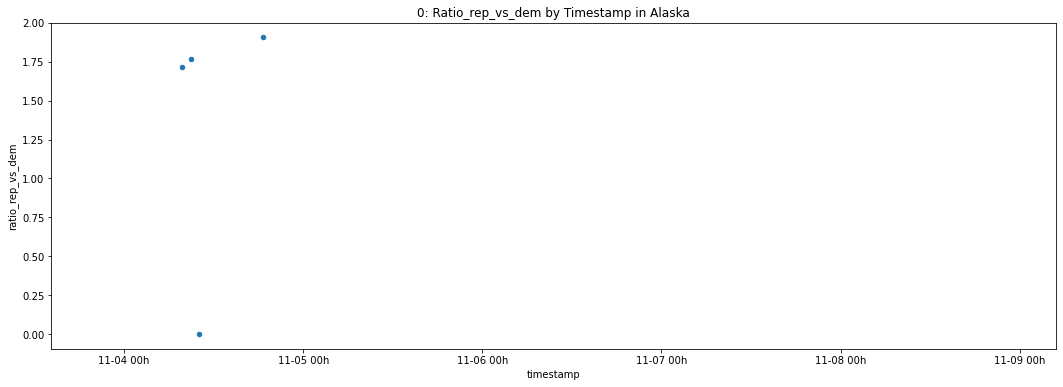

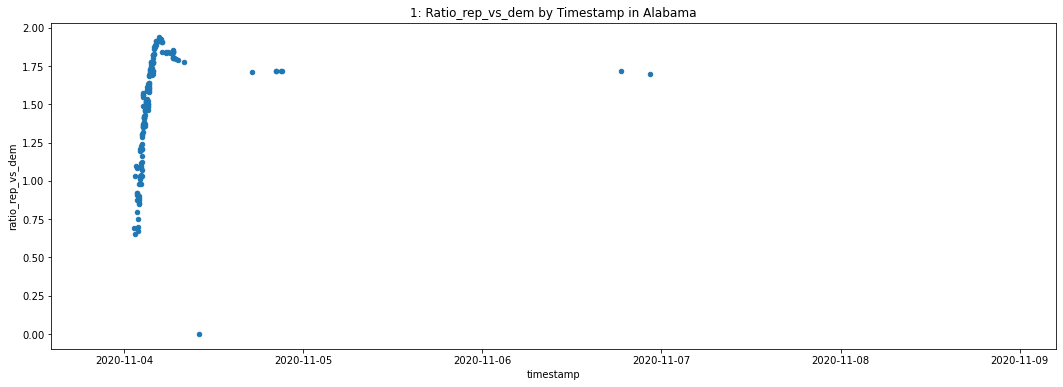

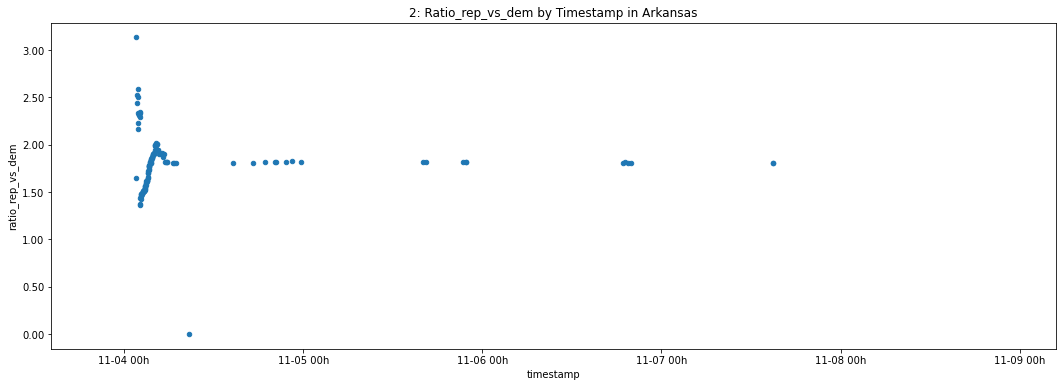

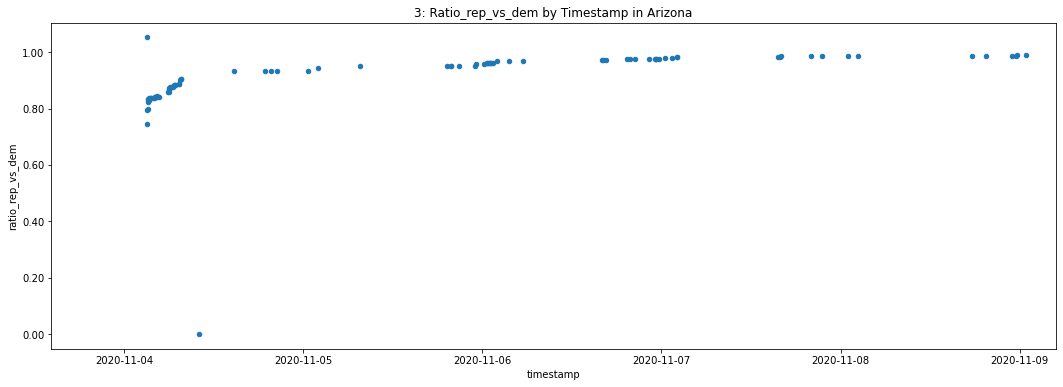

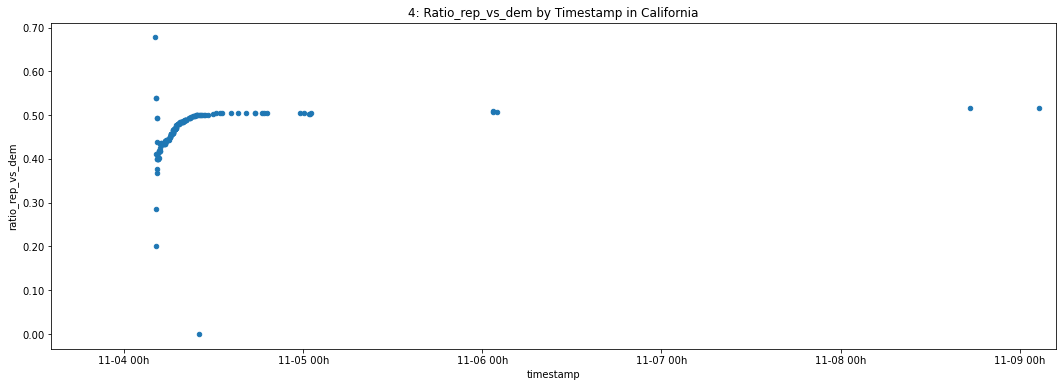

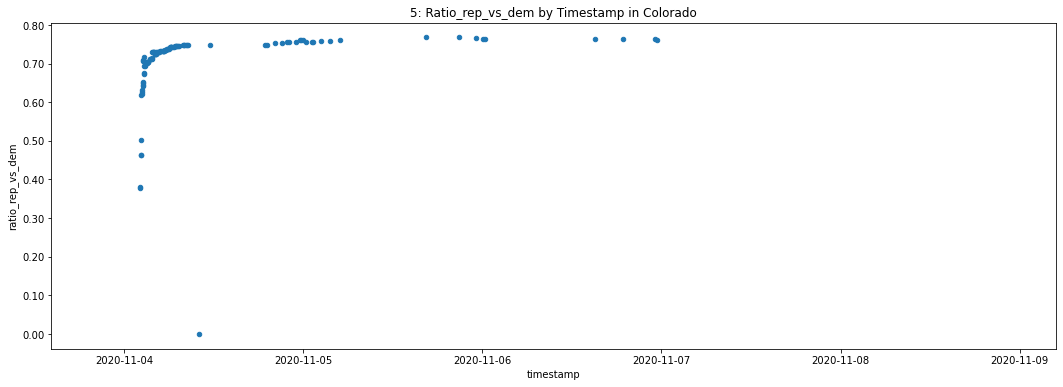

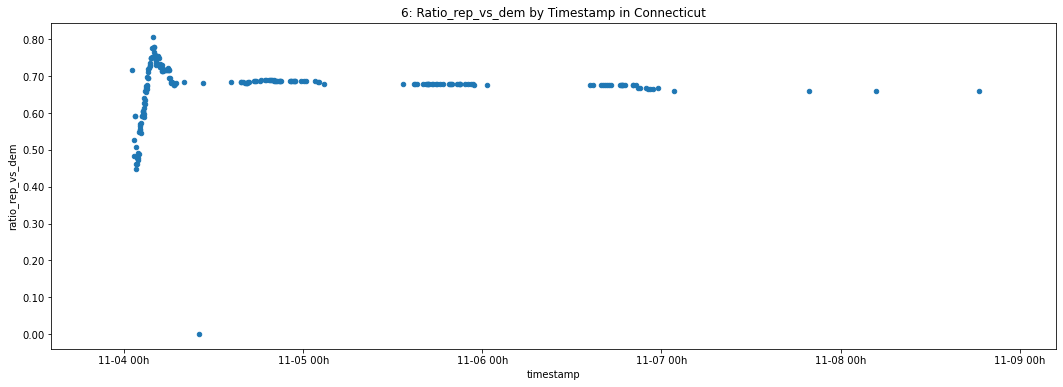

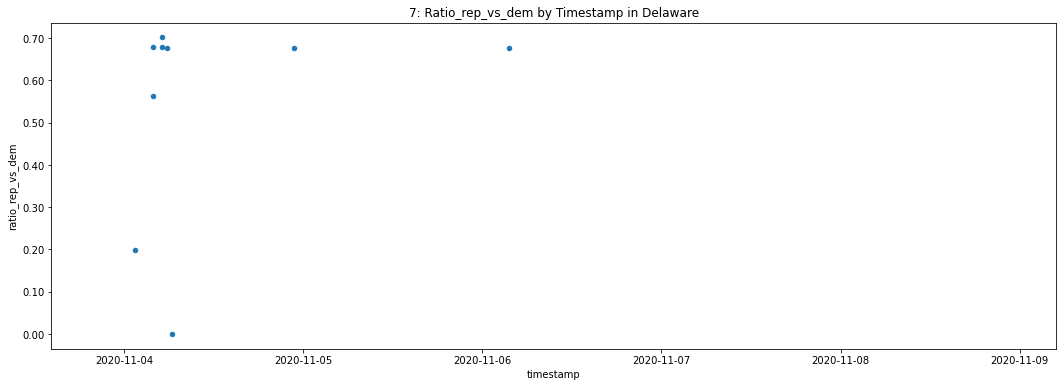

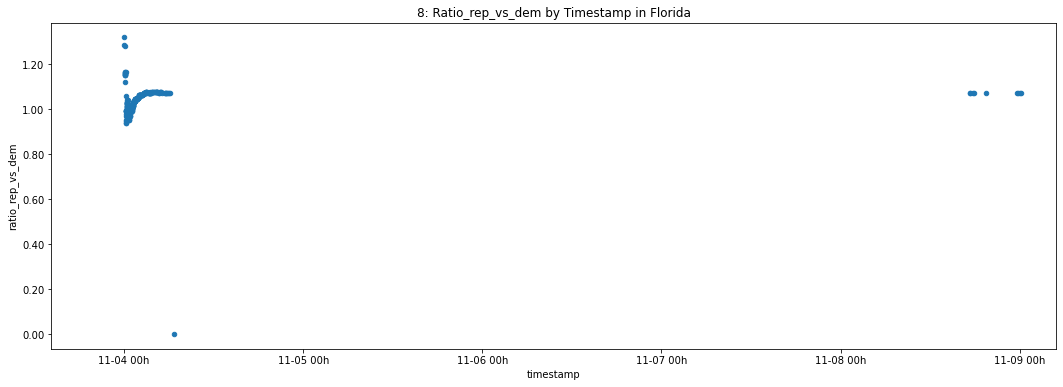

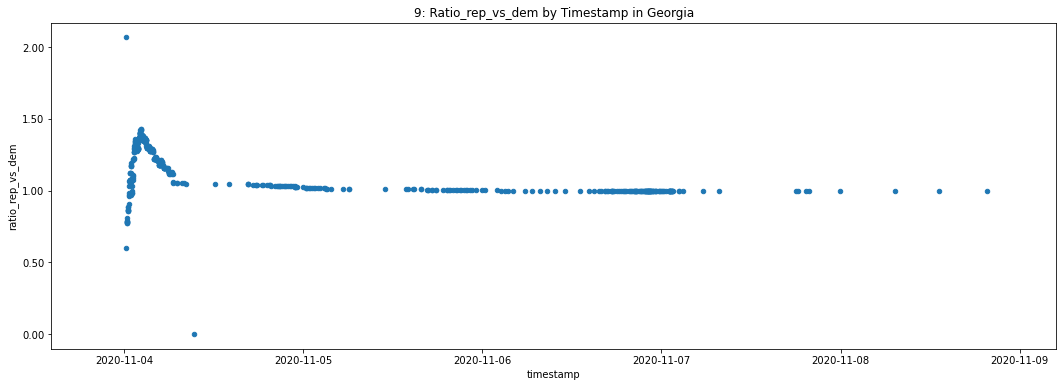

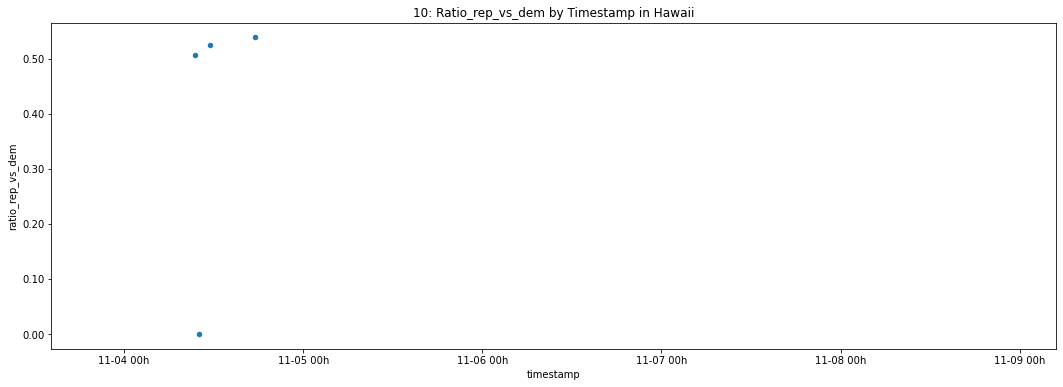

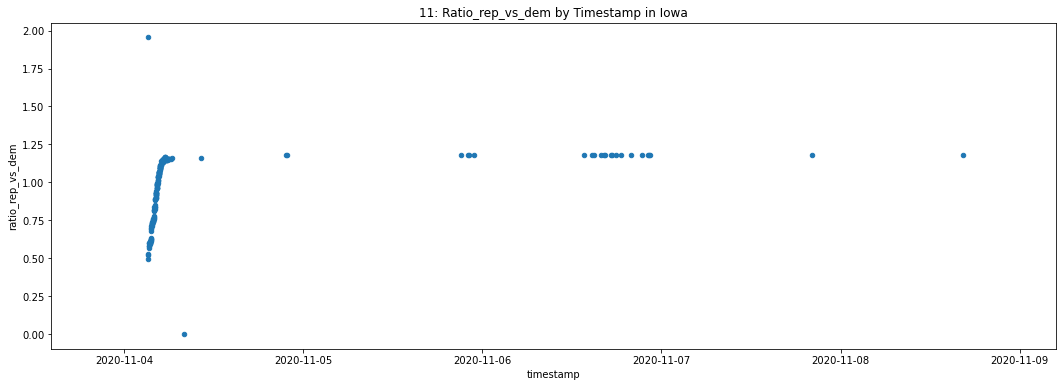

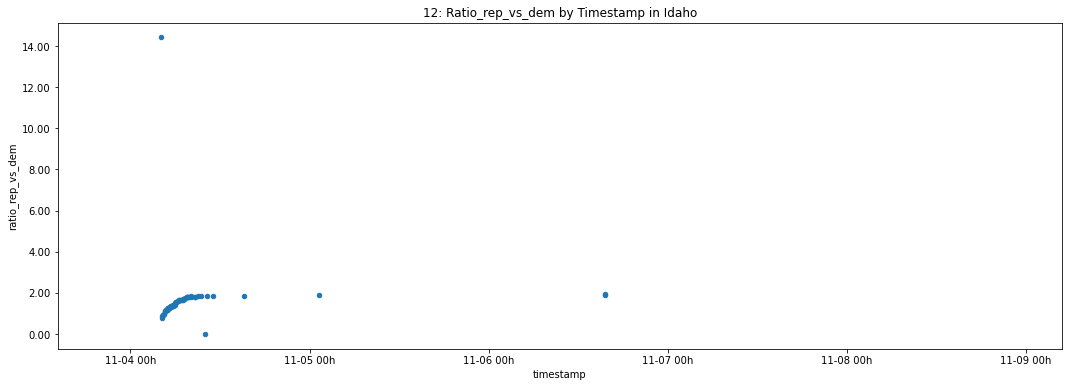

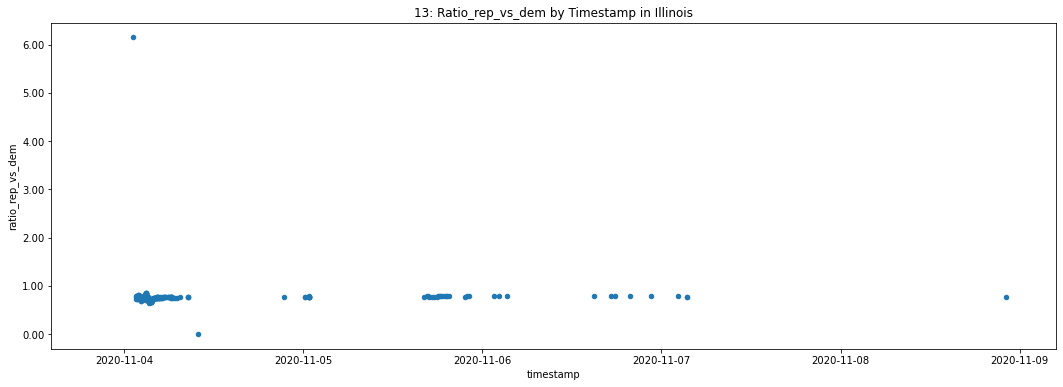

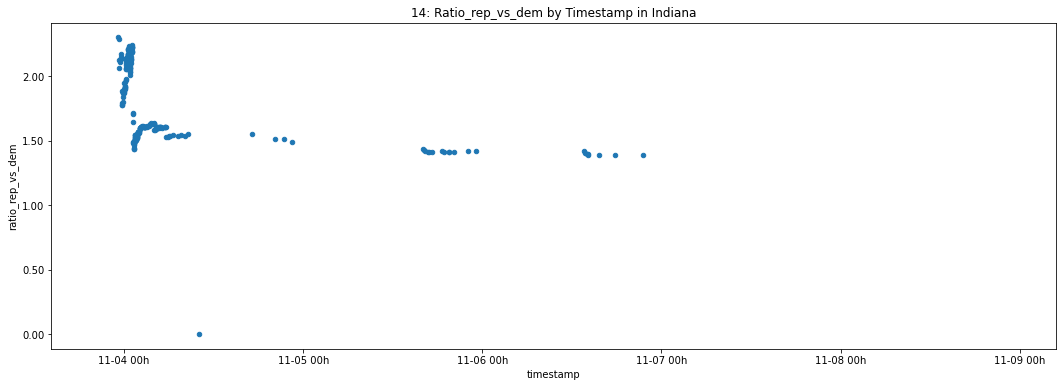

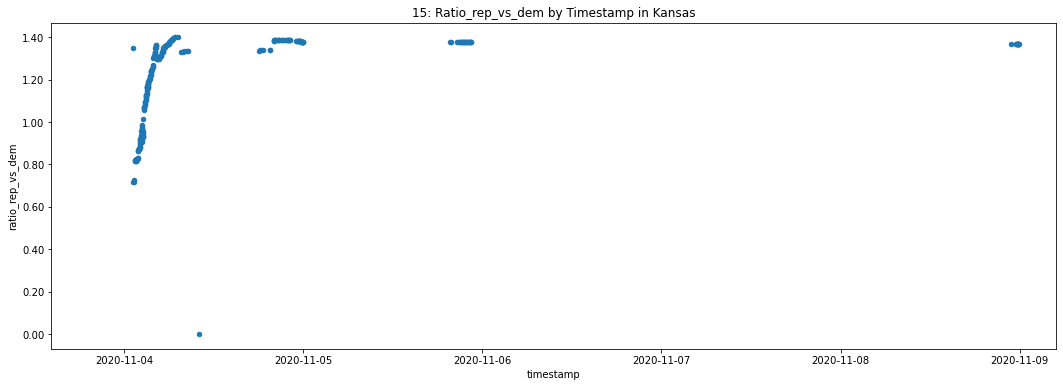

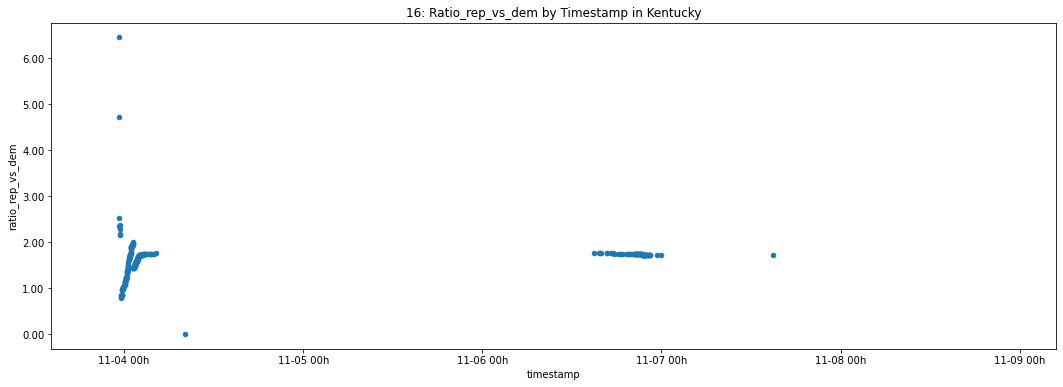

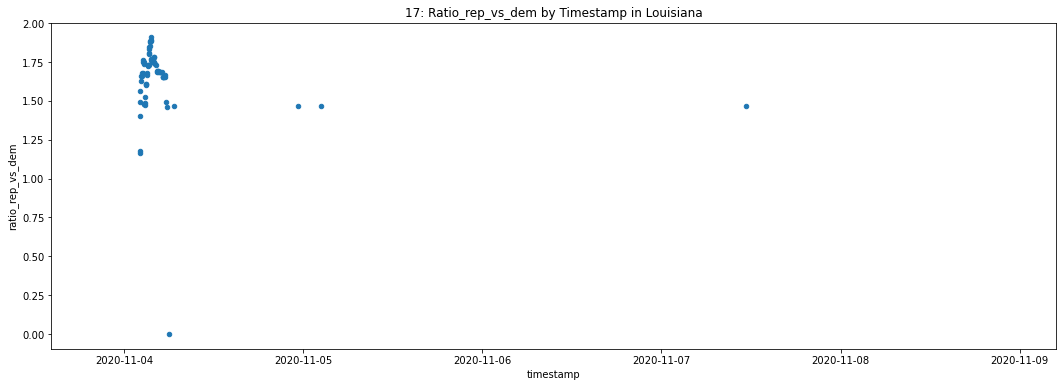

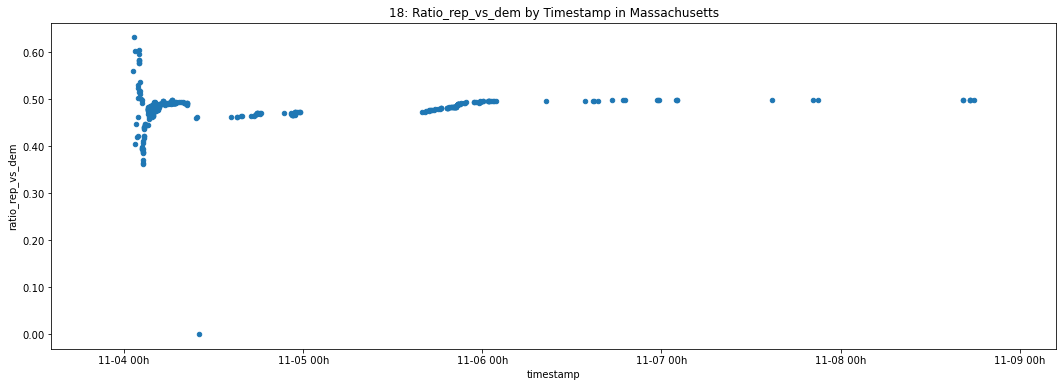

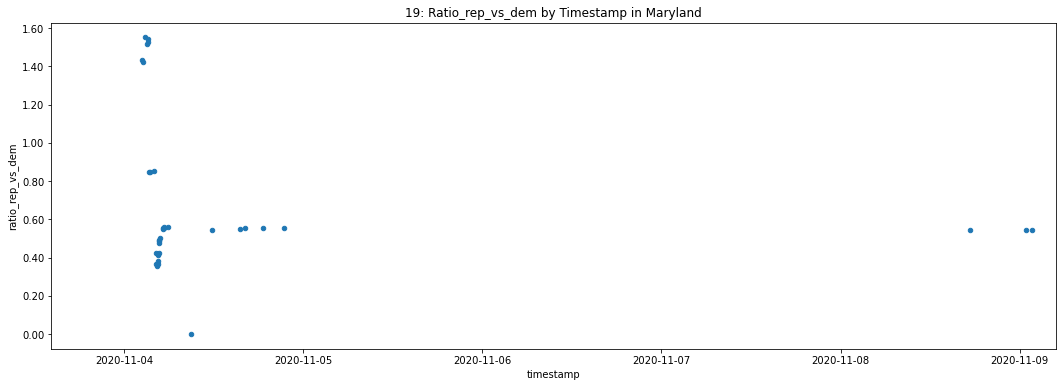

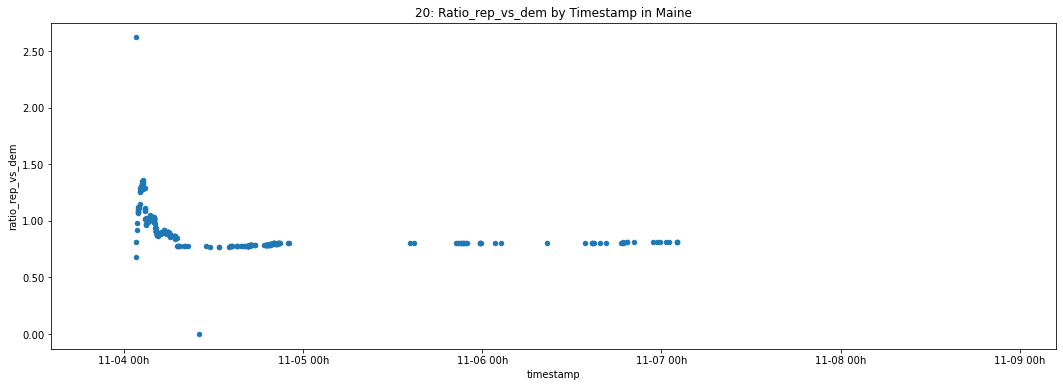

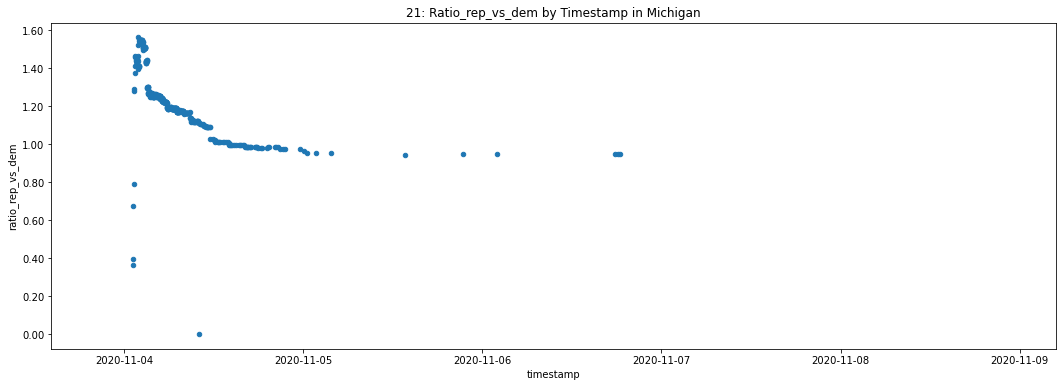

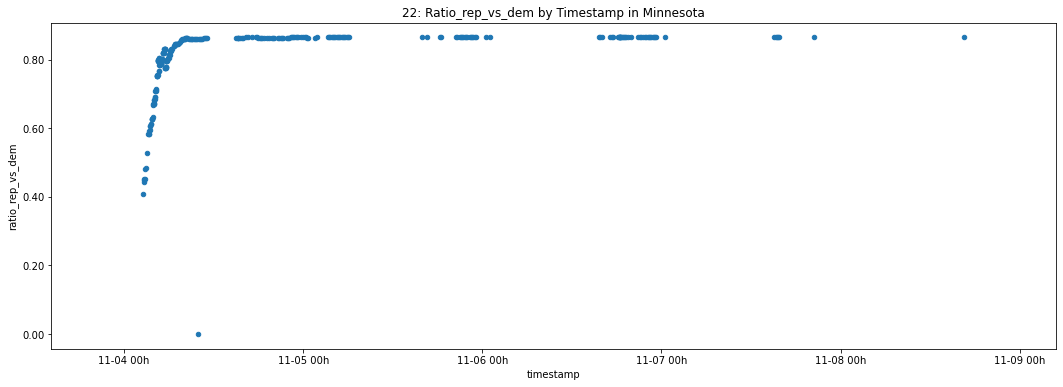

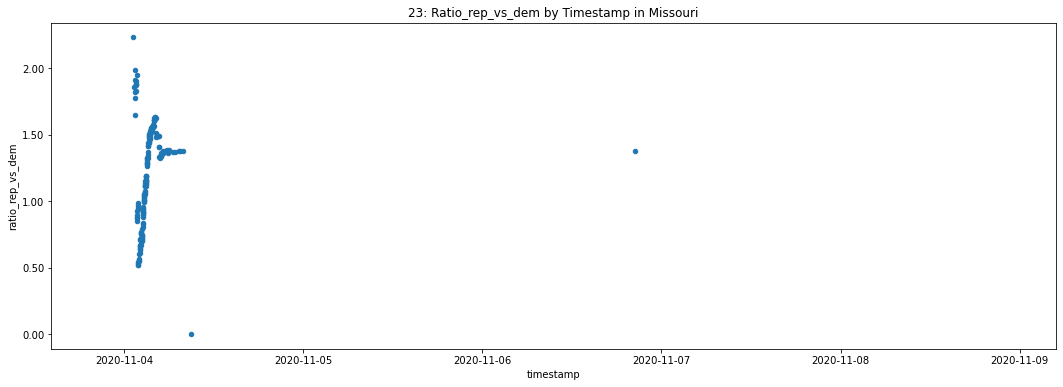

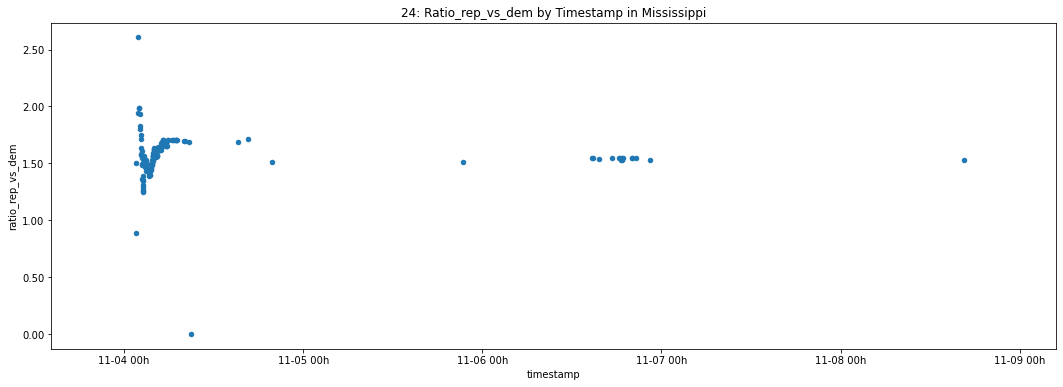

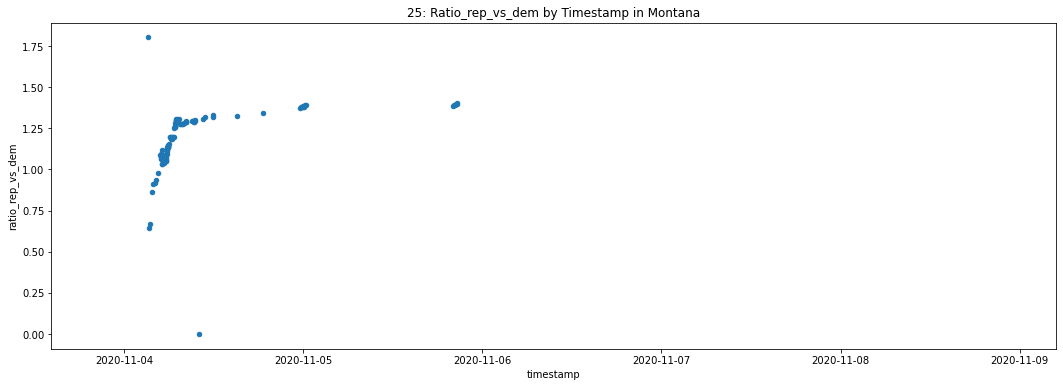

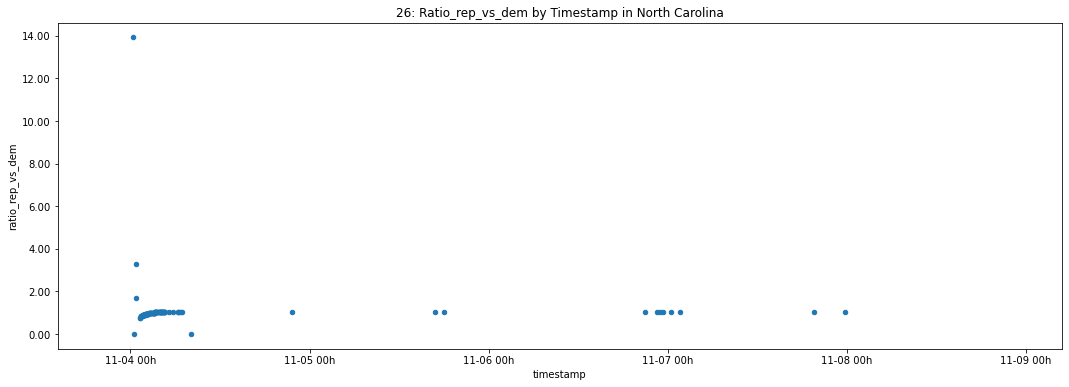

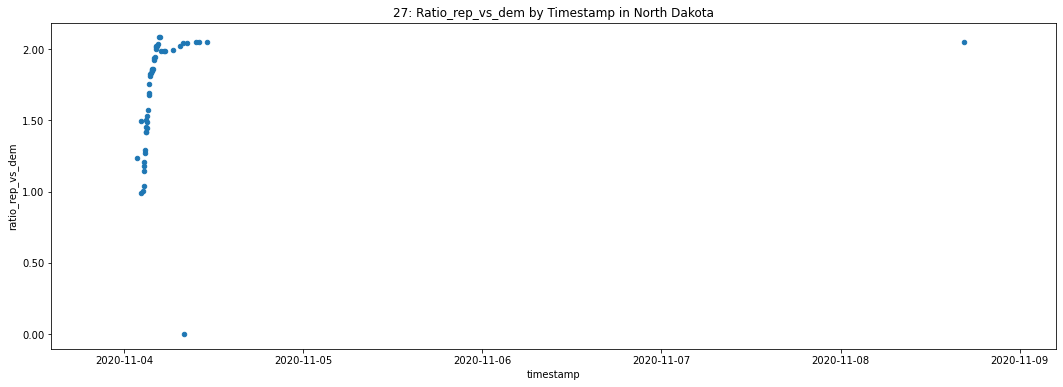

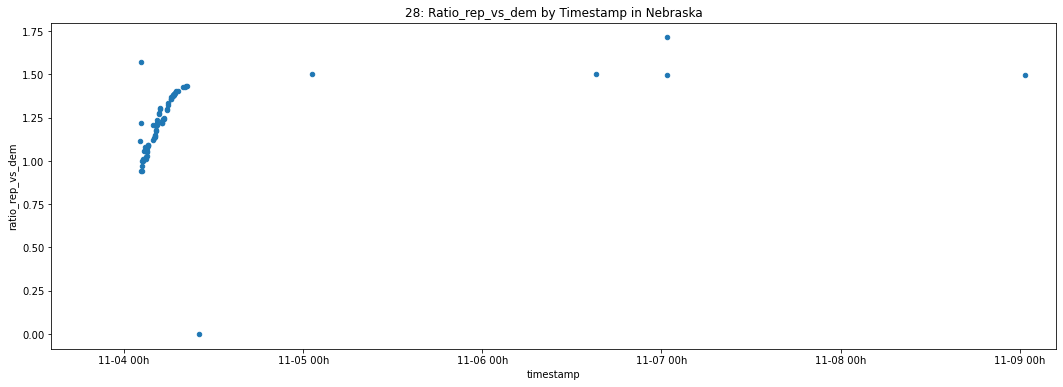

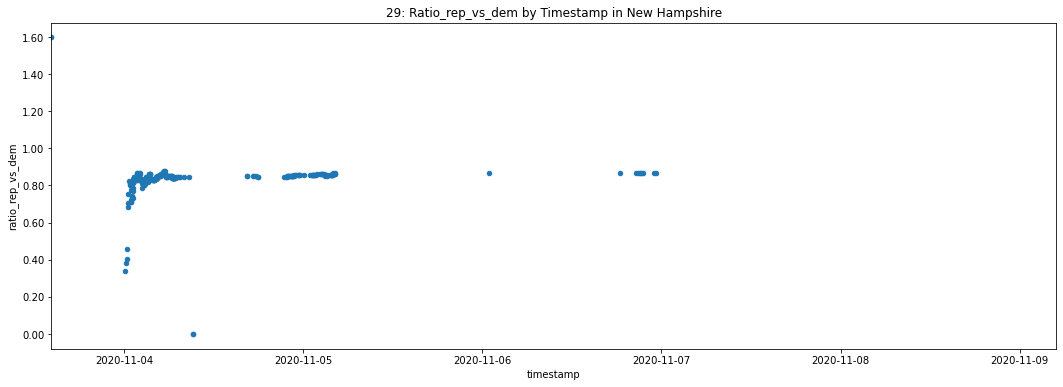

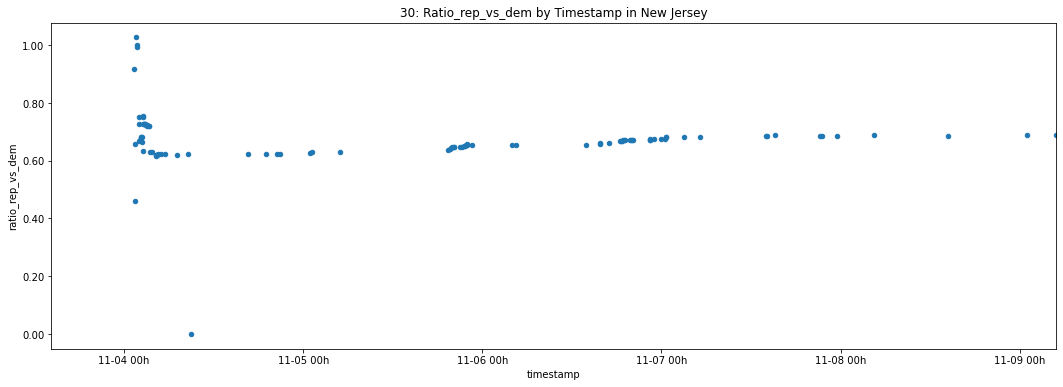

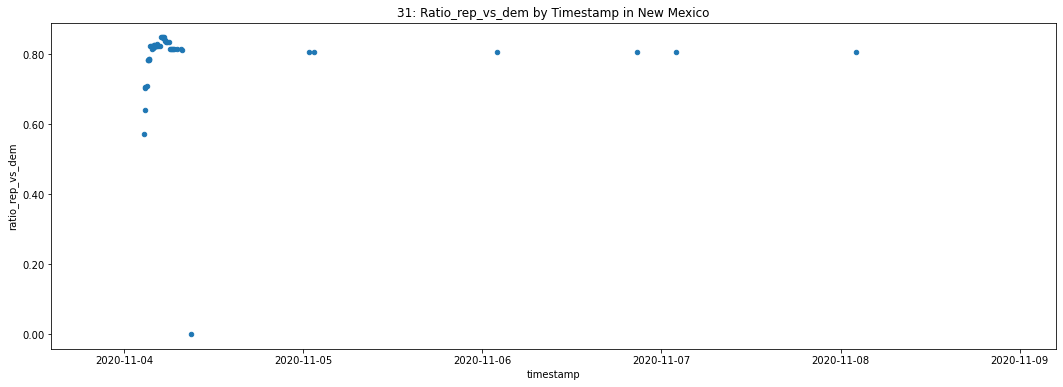

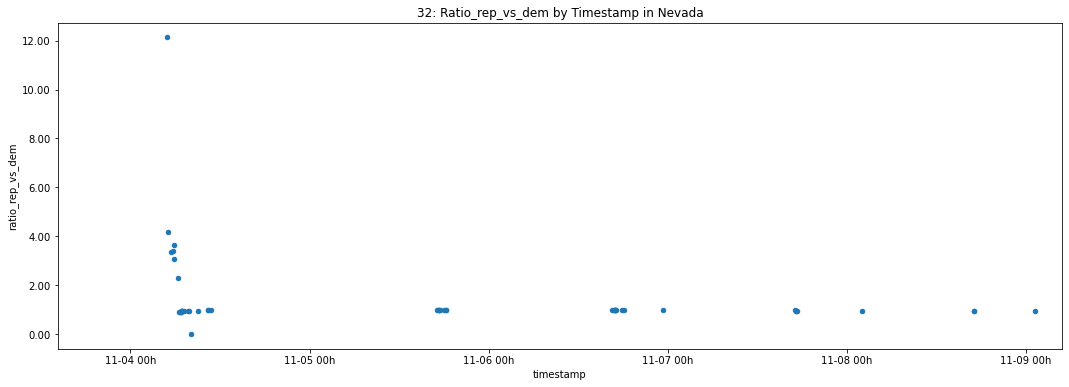

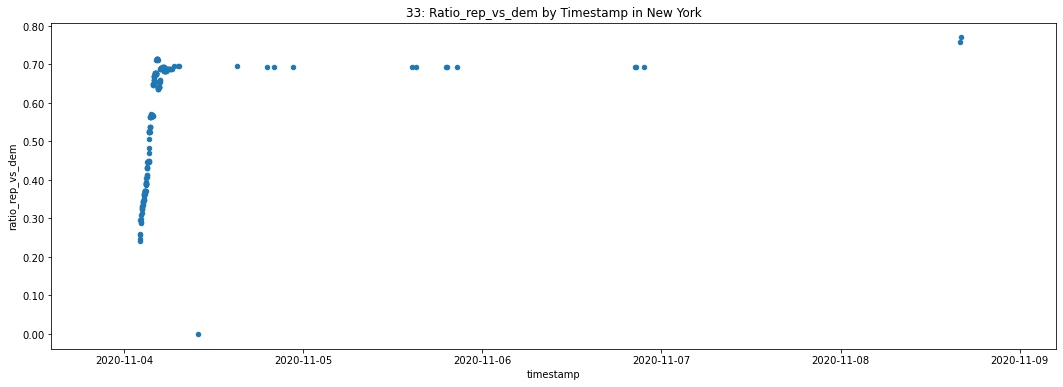

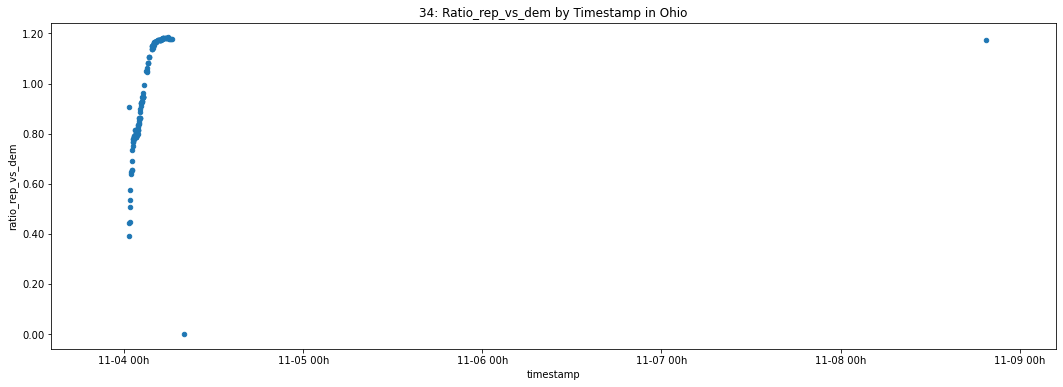

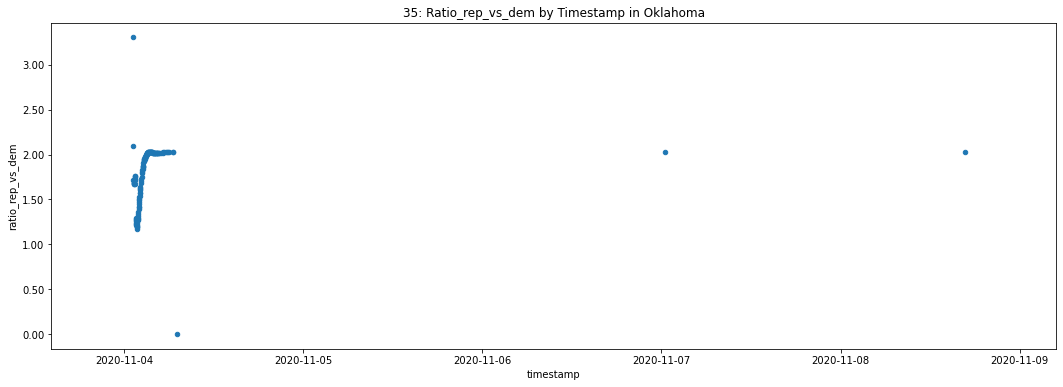

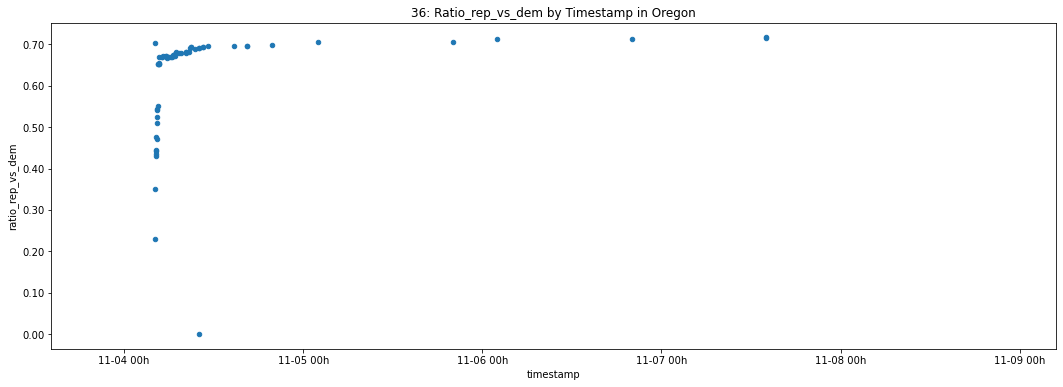

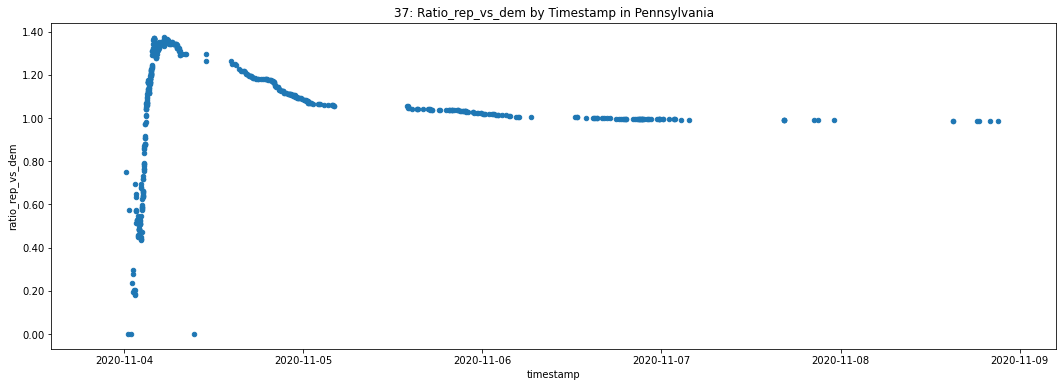

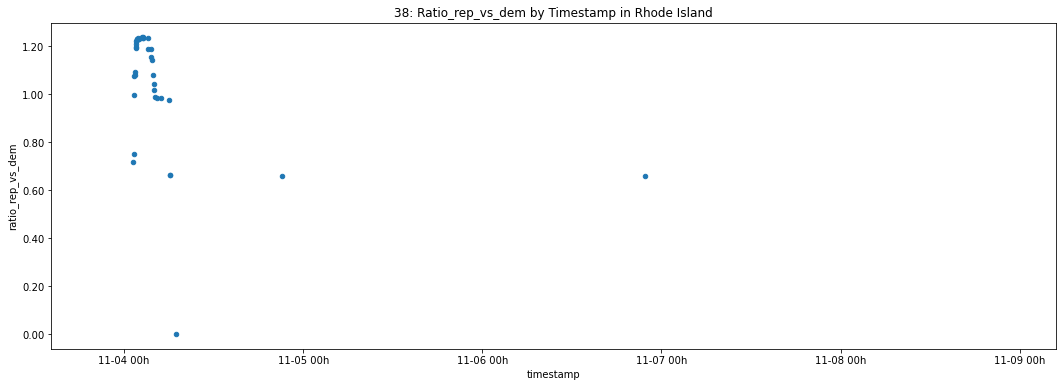

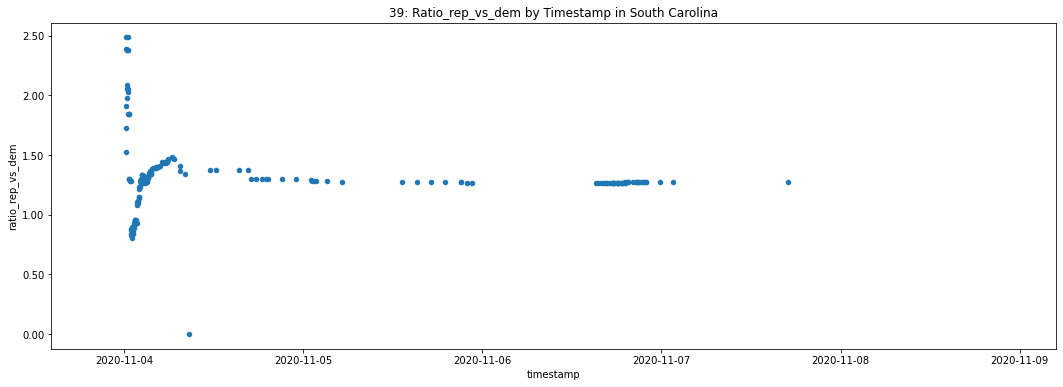

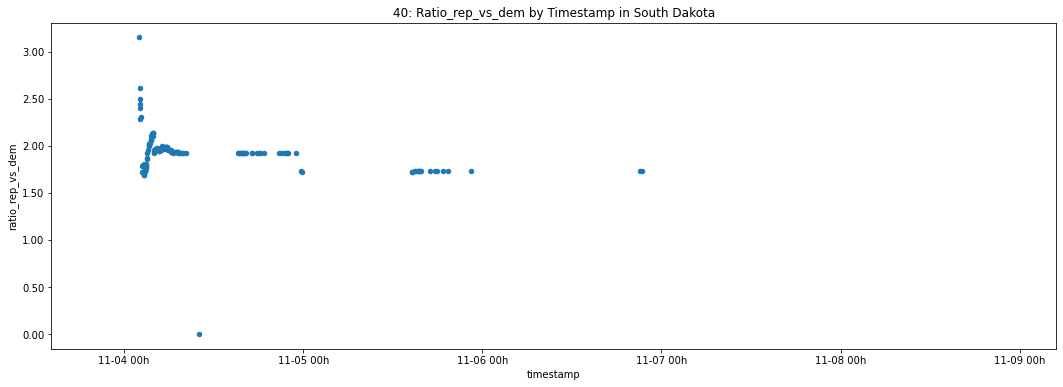

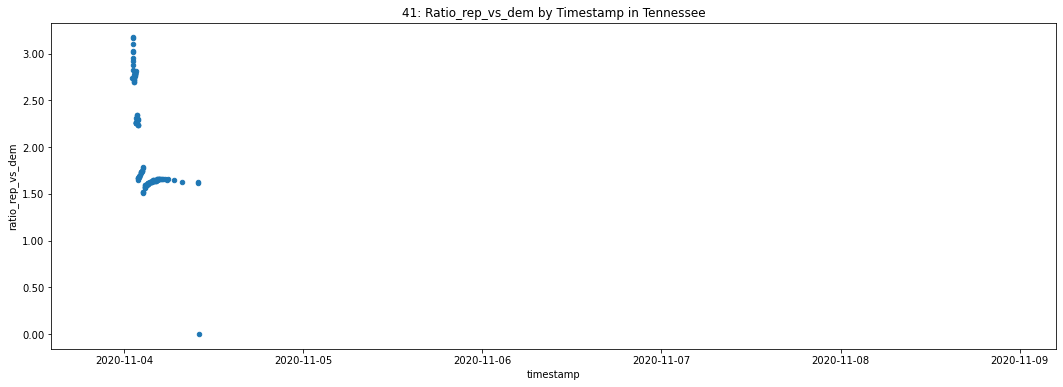

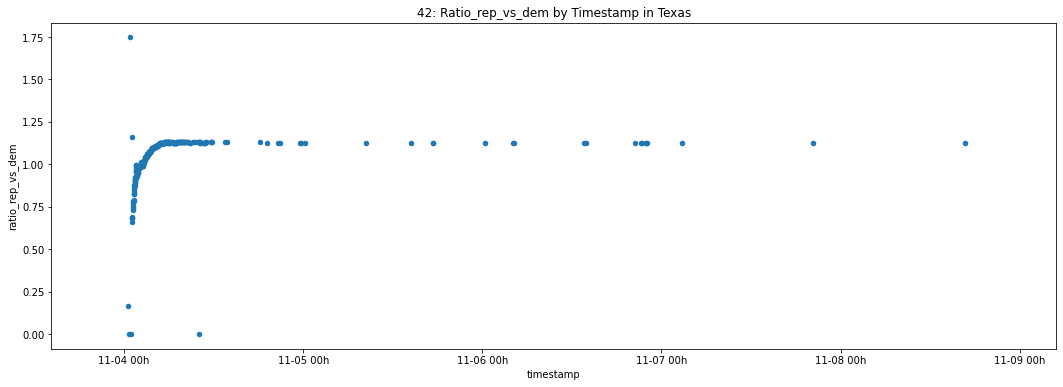

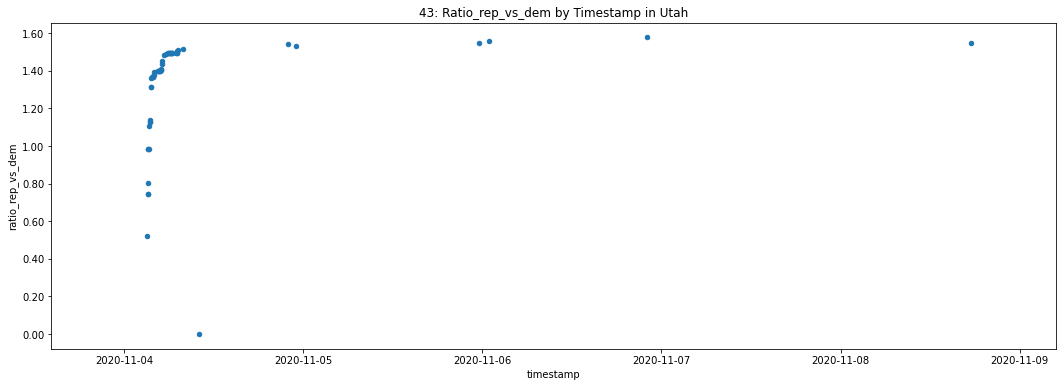

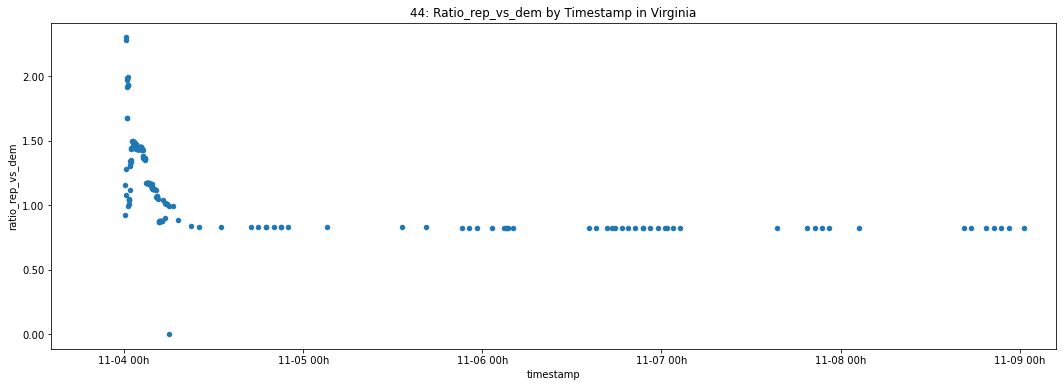

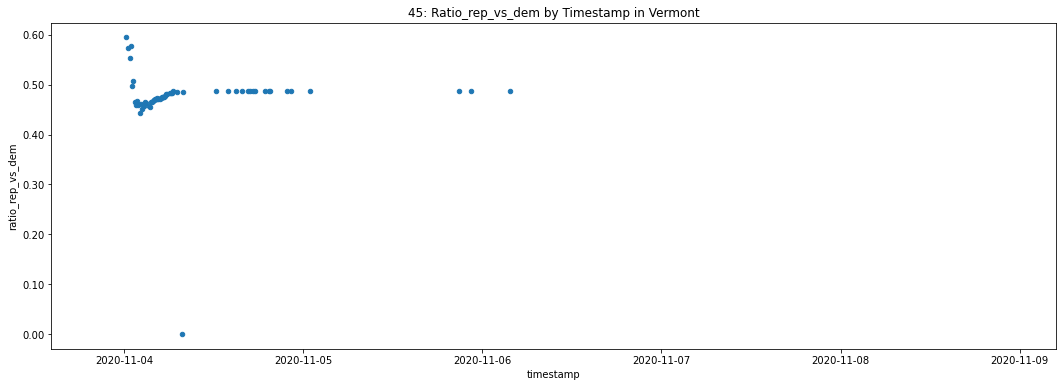

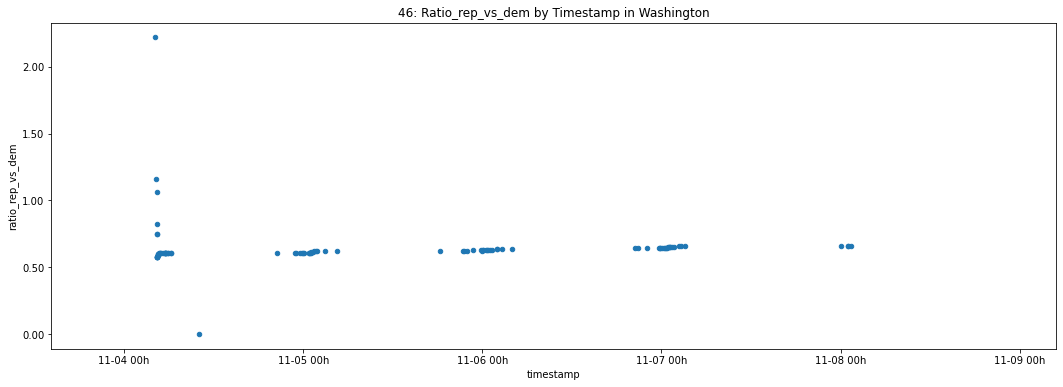

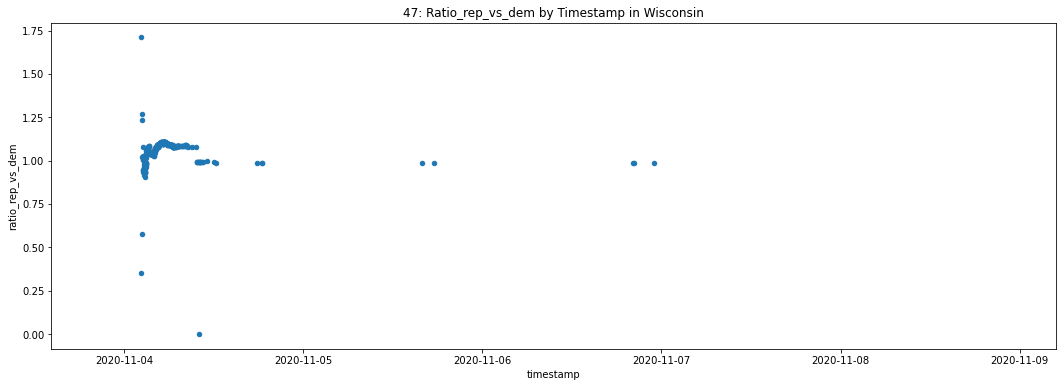

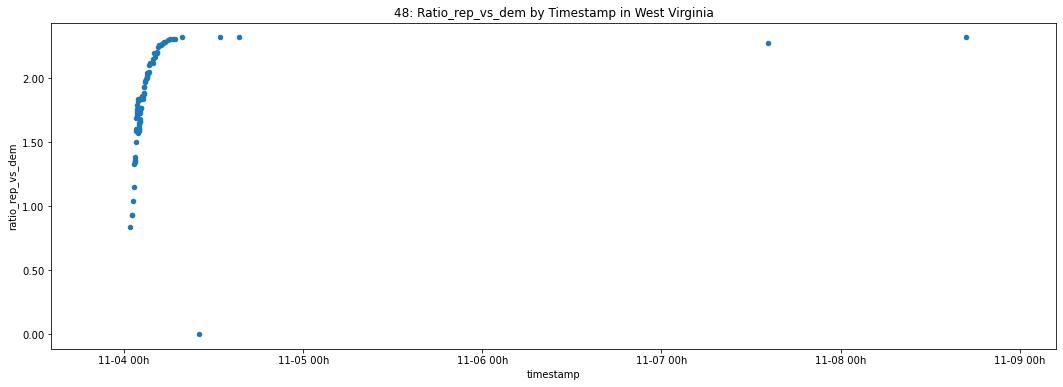

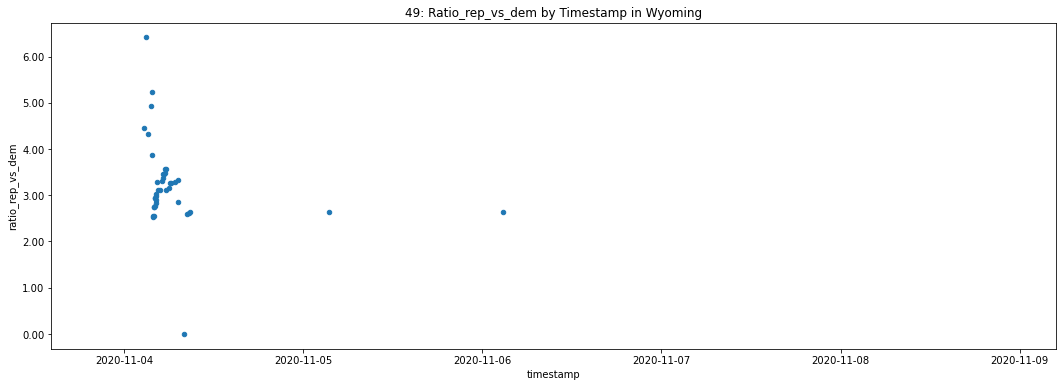

In [17]:
# Ratio between parties through time

chartset(resultsByState, 'timestamp', 'ratio_rep_vs_dem', states)